In [1]:
import pandas as pd
import numpy as np
import time

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')

import facts
from facts.models import customLogisticRegression
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_object, save_object

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dataset

In [2]:
def preprocess_adult(df):
    df = df.drop(columns=["fnlwgt", "education"])
    cols = list(df.columns)
    df[cols] = df[cols].replace([" ?"], np.nan)
    df = df.dropna()
    df["relationship"] = df["relationship"].replace([" Husband", " Wife"], " Married")
    df["income"] = np.where((df["income"] == " <=50K"), 0, 1)
    
    return df

In [123]:
nbins = 10
sup_thres = 0.01

In [124]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

df = pd.read_csv(urlfile)
df = preprocess_adult(df)

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,40,Cuba,0


In [125]:
# df["hours-per-week"] = pd.cut(
#     df["hours-per-week"],
#     bins=[0.9, 25, 39, 40, 55, 100],
#     labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"],
# )
df["hours-per-week"] = pd.cut(df["hours-per-week"], bins=nbins)
df["age"] = pd.qcut(df["age"], q=nbins)
df["capital-loss"] = pd.cut(df["capital-loss"], bins=nbins)
df["capital-gain"] = pd.cut(df["capital-gain"], bins=nbins)

In [126]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [128]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 4.25 s
Wall time: 4.64 s


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])

In [129]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     10205
           1       0.72      0.60      0.65      3362

    accuracy                           0.84     13567
   macro avg       0.80      0.76      0.77     13567
weighted avg       0.84      0.84      0.84     13567



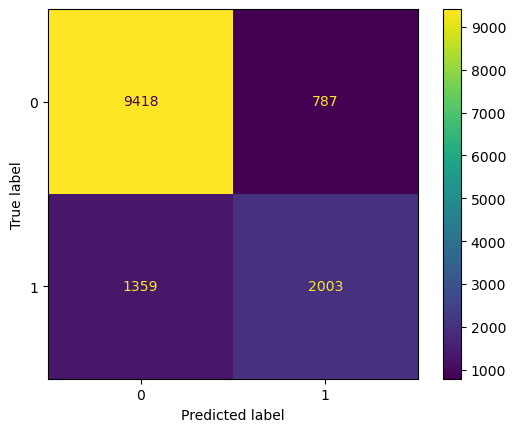

In [130]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Rules

In [131]:
start_time = time.time()
ifthens_coverage_correctness, run_stats = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp = sup_thres,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = True
)
end_time = time.time()

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Number of frequent itemsets for affected: {' Female': 26173, ' Male': 25569}
Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████| 25569/25569 [00:00<00:00, 380132.63it/s]


Number of subgroups in the intersection: 12093
Number of frequent itemsets for the unaffected: 60006
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████████████████████████████████████████████████████████████████████| 12093/12093 [00:02<00:00, 4059.84it/s]


Computing correctenesses for all valid if-thens.


100%|████████████████████████████████████████████████████████████████████████████| 87687/87687 [44:39<00:00, 32.73it/s]


Number of if-thens: 87687


In [132]:
run_stats["triples-no"] = len(ifthens_coverage_correctness)
run_stats["subgroup-no"] = len(rules_by_if)
run_stats["valid-if-thens-time"] = end_time - start_time

## Calculation of cumulative correctness for all if clauses

In [133]:
num_features = ['education-num']
cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = ['hours-per-week', 'capital-gain', 'capital-loss']

In [134]:
feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4, "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features

comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=False
)
params = ParameterProxy(featureChanges=comparators)

In [135]:
start_time = time.time()
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="sex", params=params)
end_time = time.time()

100%|████████████████████████████████████████████████████████████████████████████| 10975/10975 [13:56<00:00, 13.11it/s]


In [136]:
run_stats["cumulative-time"] = end_time - start_time

In [137]:
run_stats

{'freq-itemsets-no': {' Female': 26173, ' Male': 25569},
 'inter-groups-no': 12093,
 'unaff-freq-itemsets-no': 60006,
 'triples-no': 87687,
 'subgroup-no': 10975,
 'valid-if-thens-time': 2686.795792579651,
 'cumulative-time': 836.9749436378479}

In [138]:
len(rules_by_if)

10975

## Macro Viewpoint

### Equal Cost of Effectiveness (Macro)

In [139]:
start_time = time.time()

In [140]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If marital-status =  Divorced, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.03% covered out of 6607
		Make marital-status =  Married-civ-spouse with effectiveness 54.41%.
		Aggregate cost of the above recourses = 5.00
	Protected Subgroup ' Female', 2.40% covered out of 4170
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty, race =  Asian-Pac-Islander with effectiveness 53.00%.
		Aggregate cost of the above recourses = 109.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 104.
If occupation =  Adm-clerical, race =  White, relationship =  Married:
	Protected Subgroup ' Male', 2.32% covered out of 6607
		Make occupation =  Exec-managerial with effectiveness 59.48%.
		Make occupation =  Prof-specialty with effectiveness 53.59%.
		Make occupation =  Tech-support with effectiveness 50.98%.
		Aggregate cost of the above recourses = 4.00
	Protected Subgroup ' Female', 3.00% covered out of 4170
		Make occupation =  Prof-special

### Equal Choice for Recourse

In [141]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If capital-loss = (-4.356, 435.6], hours-per-week = (30.4, 40.2], occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Male', 3.59% covered out of 6607
		Make hours-per-week = (40.2, 50.0], occupation =  Exec-managerial with effectiveness 35.02%.
		Make occupation =  Prof-specialty with effectiveness 24.05%.
		Make occupation =  Exec-managerial with effectiveness 27.43%.
		Make hours-per-week = (40.2, 50.0], occupation =  Prof-specialty with effectiveness 33.33%.
		Make hours-per-week = (40.2, 50.0], occupation =  Sales with effectiveness 28.69%.
		Make hours-per-week = (59.8, 69.6], occupation =  Exec-managerial with effectiveness 35.02%.
		Make hours-per-week = (59.8, 69.6], occupation =  Prof-specialty with effectiveness 32.91%.
		Make occupation =  Tech-support with effectiveness 22.36%.
		Make hours-per-week = (59.8, 69.6], occupation =  Sales with effectiveness 27.00%.
		Make hours-per-week = (50.0, 59.8], occupation =  Exec-managerial with effectiveness 35.02%.
		Mak

## Micro viewpoint

### Equal (Conditional) Mean Recourse

If occupation =  Sales, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.66% covered out of 6607
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 0.57% and counterfactual cost = 4.0.
		Make relationship =  Married with effectiveness 0.57% and counterfactual cost = 5.0.
		Make occupation =  Exec-managerial, relationship =  Married with effectiveness 0.57% and counterfactual cost = 9.0.
		Make occupation =  Prof-specialty, relationship =  Married with effectiveness 0.57% and counterfactual cost = 9.0.
		Make occupation =  Craft-repair, relationship =  Married with effectiveness 0.57% and counterfactual cost = 9.0.
		Make occupation =  Adm-clerical, relationship =  Married with effectiveness 0.57% and counterfactual cost = 9.0.
		Make occupation =  Tech-support, relationship =  Married with effectiveness 0.57% and counterfactual cost = 9.0.
		Make occupation =  Pr

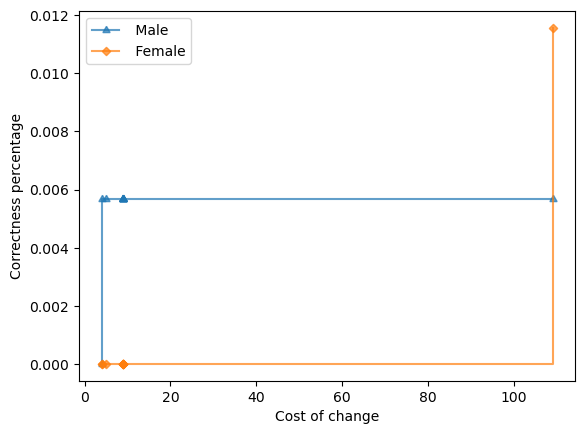

If Workclass =  Private, marital-status =  Never-married, native-country =  United-States, race =  Black, relationship =  Own-child:
	Protected Subgroup ' Male', 1.45% covered out of 6607
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.04% and counterfactual cost = 10.0.
		Make marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 1.04% and counterfactual cost = 110.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 1.04% and counterfactual cost = 112.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 1.04% and counterfactual cost = 112.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 1.04% and counterfactual cost = 112.0.
		Make Workclass =  Federal-gov, mar

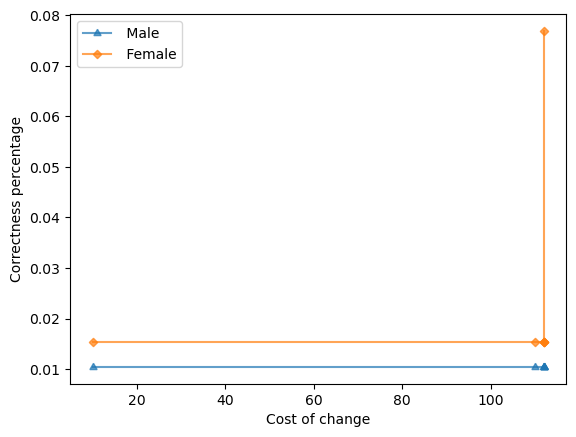

If marital-status =  Never-married, race =  Black, relationship =  Own-child:
	Protected Subgroup ' Male', 1.70% covered out of 6607
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.79% and counterfactual cost = 10.0.
		Make race =  White, relationship =  Not-in-family with effectiveness 1.79% and counterfactual cost = 105.0.
		Make marital-status =  Divorced, race =  White, relationship =  Not-in-family with effectiveness 1.79% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 1.79% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 1.79% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 2.01% covered out of 4170
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.1

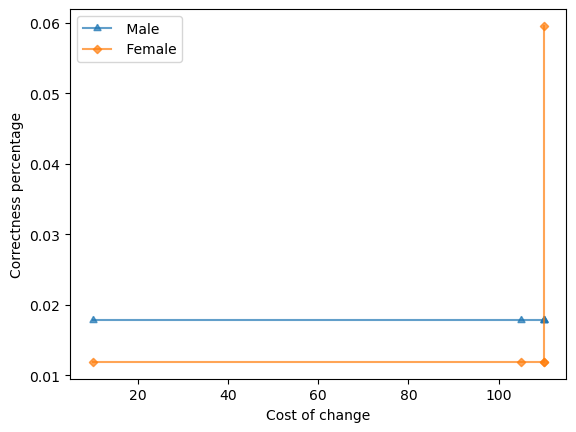

If education-num = 11, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.01% covered out of 6607
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.0.
		Make education-num = 13 with effectiveness 2.99% and counterfactual cost = 6.0.
		Make education-num = 12, relationship =  Married with effectiveness 2.99% and counterfactual cost = 8.0.
		Make education-num = 13, relationship =  Married with effectiveness 2.99% and counterfactual cost = 11.0.
		Make education-num = 13, race =  Black, relationship =  Married with effectiveness 2.99% and counterfactual cost = 111.0.
		Make education-num = 13, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 4.48% and counterfactual cost = 111.0.
		Aggregate cost of the above recourses = 41.00
	Protected Subgroup ' Female', 1.41% covered out of 4170
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.0.
		Make education-num = 13 with effectiv

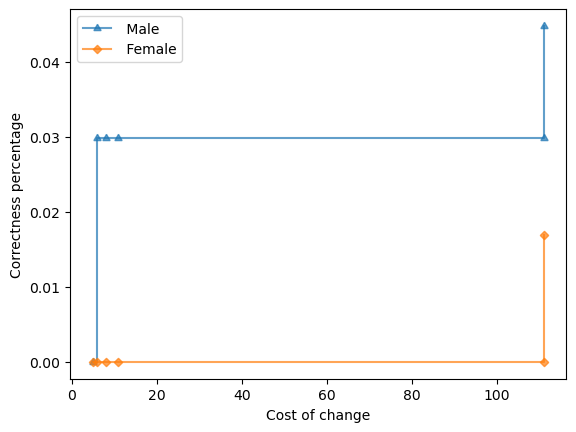

If hours-per-week = (30.4, 40.2], race =  White, relationship =  Own-child:
	Protected Subgroup ' Male', 7.42% covered out of 6607
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.0.
		Make hours-per-week = (20.6, 30.4], relationship =  Married with effectiveness 0.00% and counterfactual cost = 7.0.
		Make hours-per-week = (40.2, 50.0], relationship =  Married with effectiveness 0.20% and counterfactual cost = 7.0.
		Make hours-per-week = (40.2, 50.0], relationship =  Not-in-family with effectiveness 0.20% and counterfactual cost = 7.0.
		Make hours-per-week = (50.0, 59.8], relationship =  Married with effectiveness 0.20% and counterfactual cost = 9.0.
		Make hours-per-week = (59.8, 69.6], relationship =  Married with effectiveness 0.20% and counterfactual cost = 11.0.
		Make hours-per-week = (69.6, 79.4], relationship =  Married with effectiveness 0.20% and counterfactual cost = 13.0.
		Make race =  Black, relationship =  Married with effectiveness 0

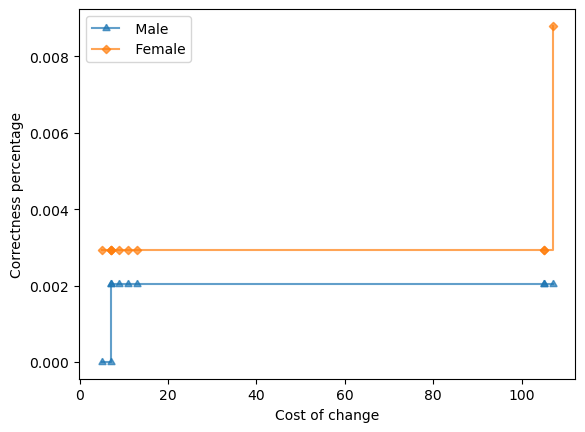

If hours-per-week = (30.4, 40.2], race =  White, relationship =  Other-relative:
	Protected Subgroup ' Male', 1.36% covered out of 6607
		Make relationship =  Married with effectiveness 2.22% and counterfactual cost = 5.0.
		Make hours-per-week = (20.6, 30.4], relationship =  Married with effectiveness 2.22% and counterfactual cost = 7.0.
		Make hours-per-week = (40.2, 50.0], relationship =  Married with effectiveness 3.33% and counterfactual cost = 7.0.
		Make hours-per-week = (40.2, 50.0], relationship =  Not-in-family with effectiveness 4.44% and counterfactual cost = 7.0.
		Make hours-per-week = (50.0, 59.8], relationship =  Married with effectiveness 4.44% and counterfactual cost = 9.0.
		Make hours-per-week = (59.8, 69.6], relationship =  Married with effectiveness 4.44% and counterfactual cost = 11.0.
		Make hours-per-week = (69.6, 79.4], relationship =  Married with effectiveness 4.44% and counterfactual cost = 13.0.
		Make race =  Black, relationship =  Married with effectiven

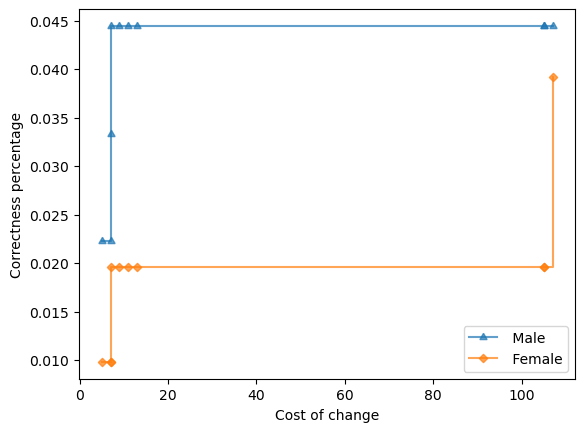

If hours-per-week = (30.4, 40.2], race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 12.73% covered out of 6607
		Make hours-per-week = (40.2, 50.0] with effectiveness 0.48% and counterfactual cost = 2.0.
		Make relationship =  Married with effectiveness 0.48% and counterfactual cost = 5.0.
		Make hours-per-week = (20.6, 30.4], relationship =  Married with effectiveness 0.48% and counterfactual cost = 7.0.
		Make hours-per-week = (40.2, 50.0], relationship =  Married with effectiveness 0.48% and counterfactual cost = 7.0.
		Make hours-per-week = (50.0, 59.8], relationship =  Married with effectiveness 0.48% and counterfactual cost = 9.0.
		Make hours-per-week = (59.8, 69.6], relationship =  Married with effectiveness 0.48% and counterfactual cost = 11.0.
		Make hours-per-week = (69.6, 79.4], relationship =  Married with effectiveness 0.48% and counterfactual cost = 13.0.
		Make race =  Black, relationship =  Married with effectiveness 0.48% and counterfactual co

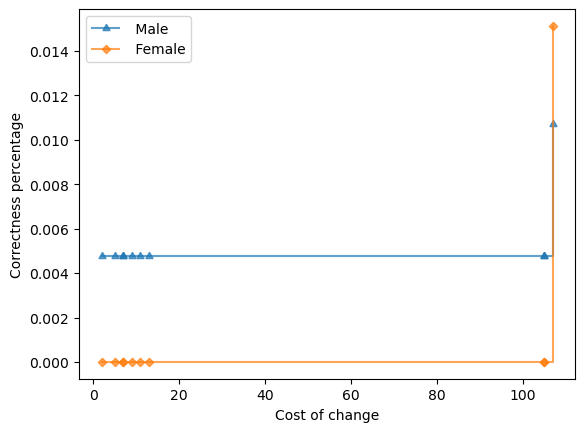

If hours-per-week = (30.4, 40.2], marital-status =  Never-married, race =  Black, relationship =  Own-child:
	Protected Subgroup ' Male', 1.01% covered out of 6607
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 2.99% and counterfactual cost = 10.0.
		Make marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 2.99% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 2.99% and counterfactual cost = 110.0.
		Make hours-per-week = (20.6, 30.4], marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 2.99% and counterfactual cost = 112.0.
		Make hours-per-week = (40.2, 50.0], marital-status =  Married-civ-spouse, race =  White, relationship =  Married with effectiveness 2.99% and counterfactual cost = 112.0.
		Make hours-per-week = (40.2, 50.0], marital-status =  Married-civ

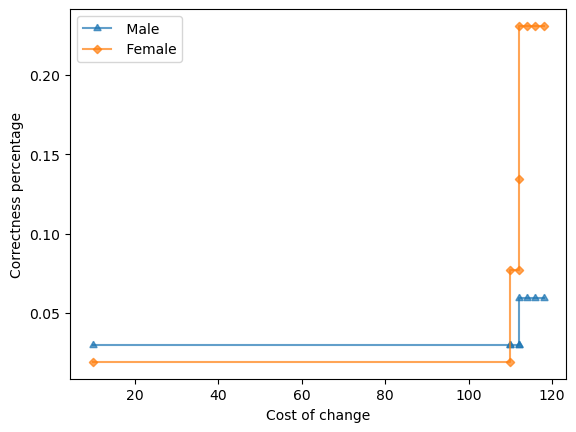

If race =  White, relationship =  Unmarried:
	Protected Subgroup ' Male', 4.03% covered out of 6607
		Make relationship =  Married with effectiveness 0.38% and counterfactual cost = 5.0.
		Make relationship =  Not-in-family with effectiveness 1.13% and counterfactual cost = 5.0.
		Make race =  Black, relationship =  Married with effectiveness 1.13% and counterfactual cost = 105.0.
		Make race =  Asian-Pac-Islander, relationship =  Married with effectiveness 1.88% and counterfactual cost = 105.0.
		Aggregate cost of the above recourses = 45.00
	Protected Subgroup ' Female', 18.42% covered out of 4170
		Make relationship =  Married with effectiveness 0.13% and counterfactual cost = 5.0.
		Make relationship =  Not-in-family with effectiveness 0.13% and counterfactual cost = 5.0.
		Make race =  Black, relationship =  Married with effectiveness 0.13% and counterfactual cost = 105.0.
		Make race =  Asian-Pac-Islander, relationship =  Married with effectiveness 0.52% and counterfactual cost =

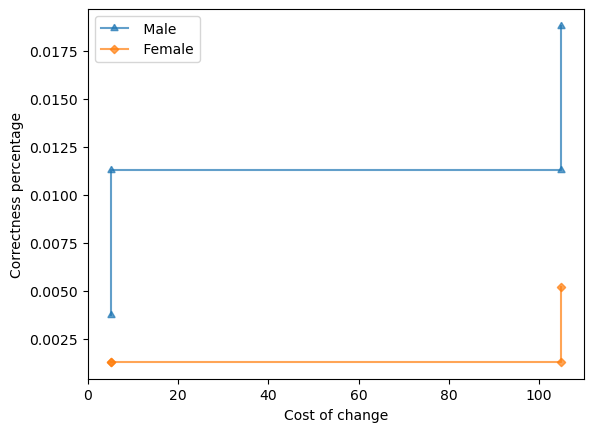

In [142]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness

If Workclass =  Local-gov, capital-loss = (-4.356, 435.6], education-num = 10, native-country =  United-States:
	Protected Subgroup ' Male', 1.06% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Private with effectiveness 14.29% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 25.71% and counterfactual cost = 2.0.
		Make Workclass =  Private, education-num = 11 with effectiveness 25.71% and counterfactual cost = 5.0.
		Make Workclass =  Private, capital-loss = (1742.4, 2178.0] with effectiveness 61.43% and counterfactual cost = 6.0.
		Make Workclass =  Private, education-num = 12 with effectiveness 61.43% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.61
	Protected Subgroup ' Female', 1.65% covered (protected subgroup population size not given)
		Make Workclass =  Private with effectiveness 0.00% and counte

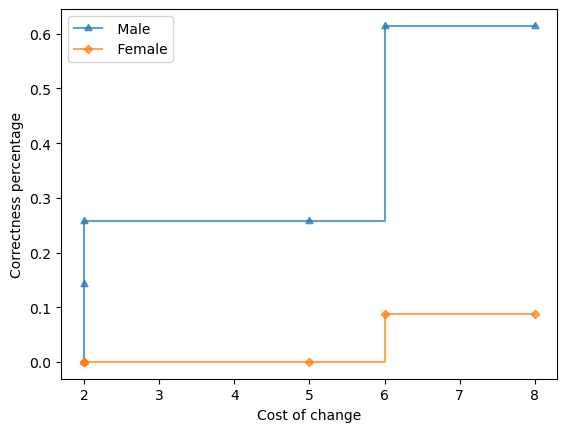

If capital-loss = (-4.356, 435.6], education-num = 9, hours-per-week = (30.4, 40.2], native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.14% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 20.00% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 20.00% and counterfactual cost = 4.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0] with effectiveness 49.33% and counterfactual cost = 5.0.
		Make hours-per-week = (40.2, 50.0], occupation =  Exec-managerial with effectiveness 61.33% and counterfactual cost = 6.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 61.33% and counterfactual cost = 7.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0], occupation =  Exec-managerial with effectiveness 64.00% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.64
	Protected Subgroup ' F

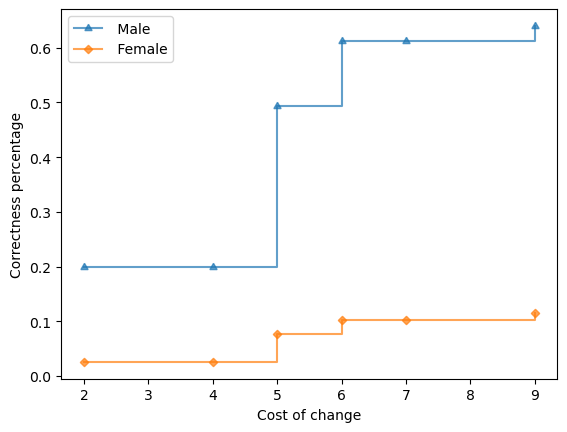

If age = (45.0, 50.0], education-num = 9, hours-per-week = (30.4, 40.2], native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 1.89% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 21.60% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 21.60% and counterfactual cost = 3.0.
		Make age = (50.0, 57.0], education-num = 10 with effectiveness 21.60% and counterfactual cost = 13.0.
		Make age = (50.0, 57.0], education-num = 10, hours-per-week = (40.2, 50.0] with effectiveness 53.60% and counterfactual cost = 15.0.
		Aggregate cost of the above recourses = 0.54
	Protected Subgroup ' Female', 1.18% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 2.04% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.04% and counterfactual cost = 3.0.
		Make age = (50.0, 57.0], education-num = 10 with effectiv

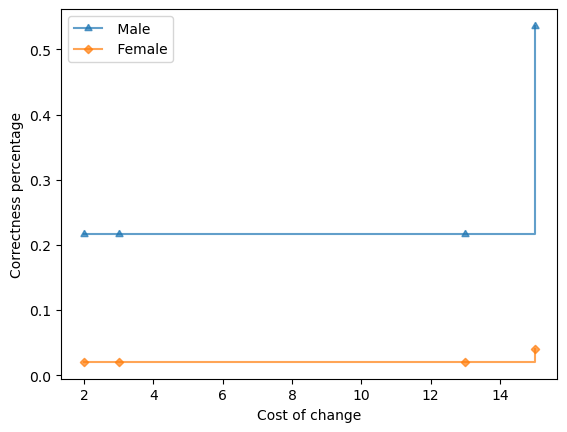

If education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 2.83% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 19.25% and counterfactual cost = 3.0.
		Make occupation =  Craft-repair with effectiveness 19.25% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 28.88% and counterfactual cost = 4.0.
		Make education-num = 10, occupation =  Craft-repair with effectiveness 28.88% and counterfactual cost = 7.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 38.50% and counterfactual cost = 7.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 45.45% and counterfactual cost = 7.0.
		Make education-num = 11, occupation =  Exec-managerial with effectiveness 57.75% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.58
	Protected Subgroup ' Female', 3.86% covered (prote

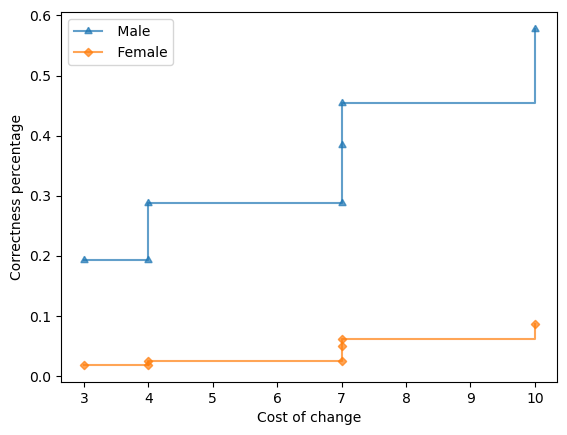

If Workclass =  Private, age = (45.0, 50.0], capital-loss = (-4.356, 435.6], native-country =  United-States:
	Protected Subgroup ' Male', 4.87% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 19.57% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 22.98% and counterfactual cost = 2.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 64.29% and counterfactual cost = 4.0.
		Make age = (50.0, 57.0] with effectiveness 64.29% and counterfactual cost = 10.0.
		Make age = (57.0, 90.0] with effectiveness 64.29% and counterfactual cost = 10.0.
		Make Workclass =  Self-emp-inc, age = (57.0, 90.0] with effectiveness 64.29% and counterfactual cost = 12.0.
		Make Workclass =  Self-emp-not-inc, age = (50.0, 57.0] with effec

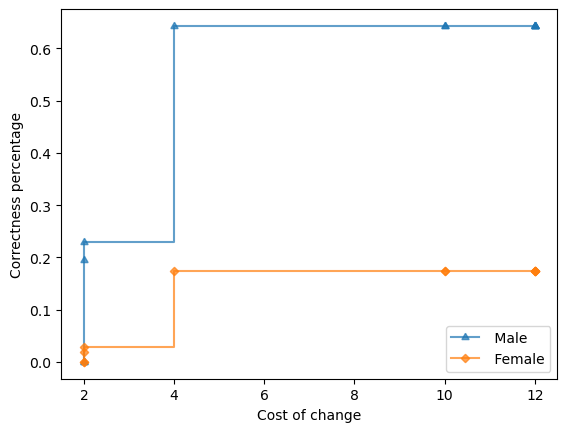

In [143]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

If hours-per-week = (30.4, 40.2], race =  White, relationship =  Married:
	Protected Subgroup ' Male', 25.09% covered (protected subgroup population size not given)
		Make hours-per-week = (20.6, 30.4] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 19.42% and counterfactual cost = 2.0.
		Make hours-per-week = (50.0, 59.8] with effectiveness 20.08% and counterfactual cost = 4.0.
		Make hours-per-week = (59.8, 69.6] with effectiveness 20.08% and counterfactual cost = 6.0.
		Make hours-per-week = (40.2, 50.0], relationship =  Not-in-family with effectiveness 28.35% and counterfactual cost = 7.0.
		Make hours-per-week = (69.6, 79.4] with effectiveness 28.35% and counterfactual cost = 8.0.
		Make race =  Black with effectiveness 28.35% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 28.35% and counterfactual cost = 100.0.
		Make hours-per-week = (40.2, 50.0], race =  Asian-Pac-Islander wit

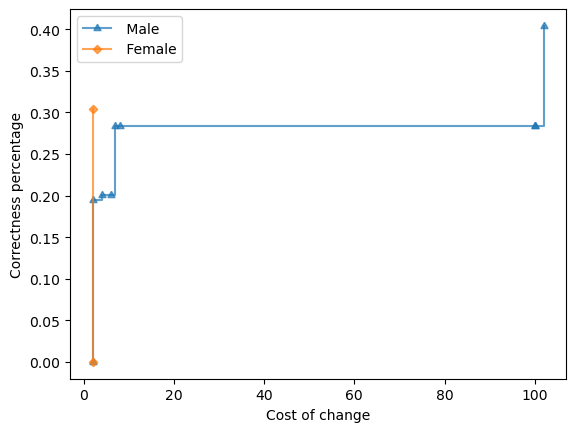

If marital-status =  Married-civ-spouse, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 4.07% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Transport-moving with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 9.67% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 24.16% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 29.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 39.78% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 4.00
	Protected Subgroup ' Female', 1.20% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiven

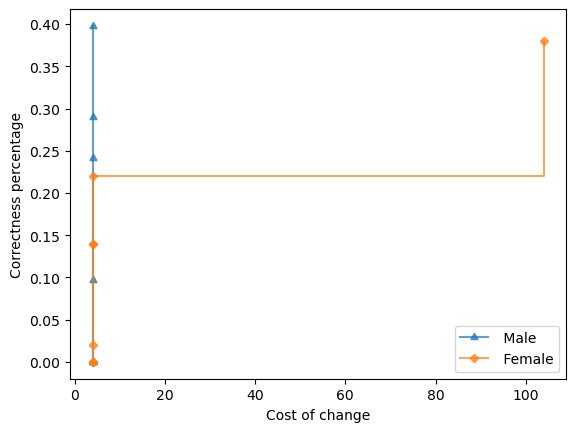

If marital-status =  Married-civ-spouse, occupation =  Other-service, race =  White, relationship =  Married:
	Protected Subgroup ' Male', 2.54% covered (protected subgroup population size not given)
		Make occupation =  Transport-moving with effectiveness 9.52% and counterfactual cost = 4.0.
		Make occupation =  Craft-repair with effectiveness 11.31% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 12.50% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 19.64% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 24.40% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 27.38% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 30.36% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 4.00
	Protected Subgroup ' Female', 1.22% covered (protected subgroup population size not given)
		Make occupation =  Cr

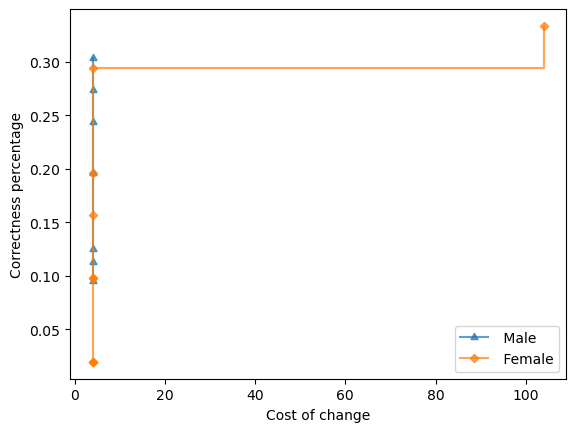

If hours-per-week = (20.6, 30.4], marital-status =  Married-civ-spouse, race =  White:
	Protected Subgroup ' Male', 1.45% covered (protected subgroup population size not given)
		Make hours-per-week = (30.4, 40.2] with effectiveness 18.75% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 34.38% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 4.00
	Protected Subgroup ' Female', 1.22% covered (protected subgroup population size not given)
		Make hours-per-week = (30.4, 40.2] with effectiveness 11.76% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 21.57% and counterfactual cost = 4.0.
		Make hours-per-week = (50.0, 59.8] with effectiveness 25.49% and counterfactual cost = 6.0.
		Make hours-per-week = (59.8, 69.6] with effectiveness 25.49% and counterfactual cost = 8.0.
		Make hours-per-week = (69.6, 79.4] with effectiveness 25.49% and counterfactual cost = 10.0.
		Make hours-per-week = (

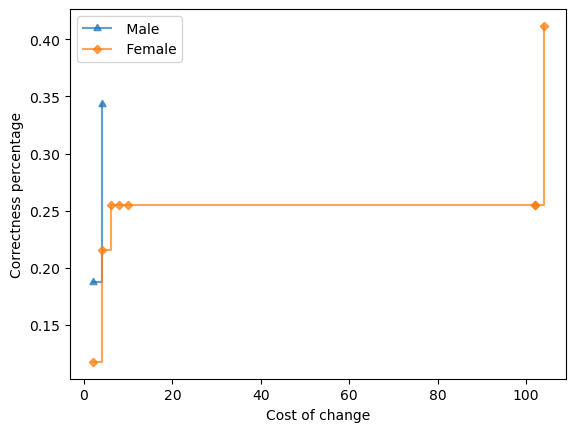

If Workclass =  Private, age = (30.0, 34.0], capital-loss = (-4.356, 435.6], marital-status =  Never-married:
	Protected Subgroup ' Male', 2.82% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 24.73% and counterfactual cost = 5.0.
		Make age = (34.0, 37.0], marital-status =  Married-civ-spouse with effectiveness 26.88% and counterfactual cost = 15.0.
		Make age = (37.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 29.57% and counterfactual cost = 15.0.
		Make Workclass =  Local-gov, age = (37.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 29.57% and counterfactual cost = 17.0.
		Make Workclass =  Self-emp-inc, age = (37.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 37.63% and counterfactual cost = 17.0.
		Aggregate cost of the above recourses = 17.00
	Protected Subgroup ' Female', 3.38% covered (protected subgroup population size not given)
		Make marital-statu

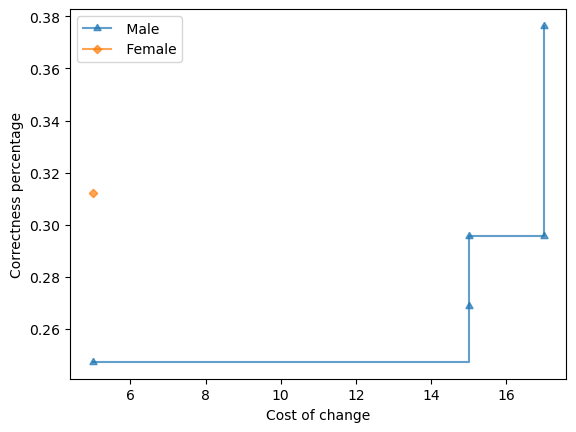

If age = (34.0, 37.0], hours-per-week = (30.4, 40.2], marital-status =  Never-married:
	Protected Subgroup ' Male', 1.20% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 17.72% and counterfactual cost = 5.0.
		Make hours-per-week = (40.2, 50.0], marital-status =  Married-civ-spouse with effectiveness 24.05% and counterfactual cost = 7.0.
		Make age = (37.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 24.05% and counterfactual cost = 15.0.
		Make age = (41.0, 45.0], marital-status =  Married-civ-spouse with effectiveness 24.05% and counterfactual cost = 15.0.
		Make age = (37.0, 41.0], hours-per-week = (40.2, 50.0], marital-status =  Married-civ-spouse with effectiveness 35.44% and counterfactual cost = 17.0.
		Aggregate cost of the above recourses = 17.00
	Protected Subgroup ' Female', 1.65% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effe

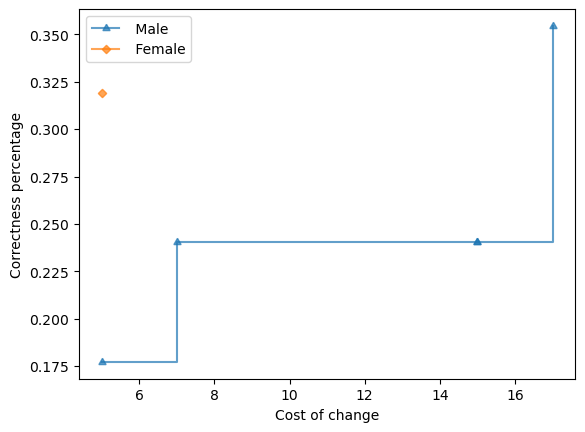

If age = (37.0, 41.0], capital-loss = (-4.356, 435.6], race =  White:
	Protected Subgroup ' Male', 8.19% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 55.45% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 4.00
	Protected Subgroup ' Female', 6.67% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 24.82% and counterfactual cost = 4.0.
		Make age = (41.0, 45.0] with effectiveness 24.82% and counterfactual cost = 10.0.
		Make age = (45.0, 50.0] with effectiveness 24.82% and counterfactual cost = 10.0.
		Make age = (41.0, 45.0], capital-loss = (1742.4, 2178.0] with effectiveness 28.78% and counterfactual cost = 14.0.
		Make age = (45.0, 50.0], capital-loss = (1742.4, 2178.0] with effectiveness 31.65% and counterfactual cost = 14.0.
		Aggregate cost of the above recourses = 14.00
	Bias against  Female due to Equal Effectiveness. Unfairnes

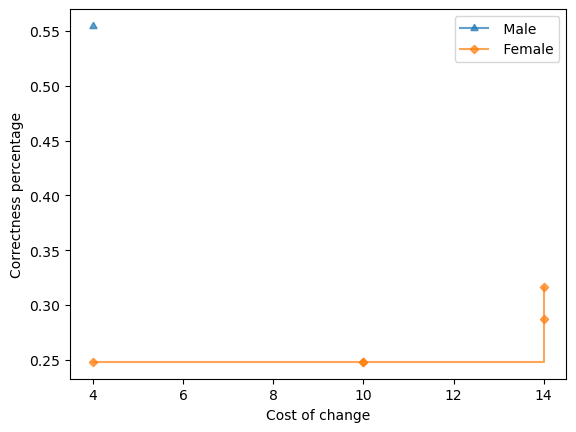

If age = (41.0, 45.0], capital-loss = (-4.356, 435.6], race =  White:
	Protected Subgroup ' Male', 5.81% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 60.94% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 4.00
	Protected Subgroup ' Female', 5.80% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 29.34% and counterfactual cost = 4.0.
		Make age = (45.0, 50.0] with effectiveness 29.34% and counterfactual cost = 10.0.
		Make age = (50.0, 57.0] with effectiveness 29.34% and counterfactual cost = 10.0.
		Make age = (50.0, 57.0], capital-loss = (1742.4, 2178.0] with effectiveness 32.23% and counterfactual cost = 14.0.
		Aggregate cost of the above recourses = 14.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


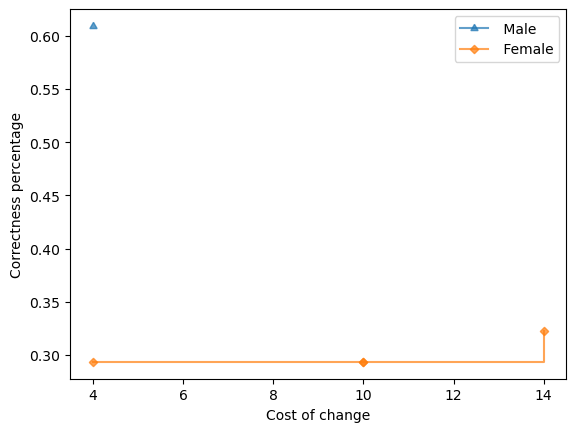

If age = (30.0, 34.0], marital-status =  Never-married:
	Protected Subgroup ' Male', 3.71% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 26.94% and counterfactual cost = 5.0.
		Make age = (34.0, 37.0], marital-status =  Married-civ-spouse with effectiveness 29.80% and counterfactual cost = 15.0.
		Make age = (37.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 33.47% and counterfactual cost = 15.0.
		Aggregate cost of the above recourses = 15.00
	Protected Subgroup ' Female', 4.65% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 35.57% and counterfactual cost = 5.0.
		Aggregate cost of the above recourses = 5.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


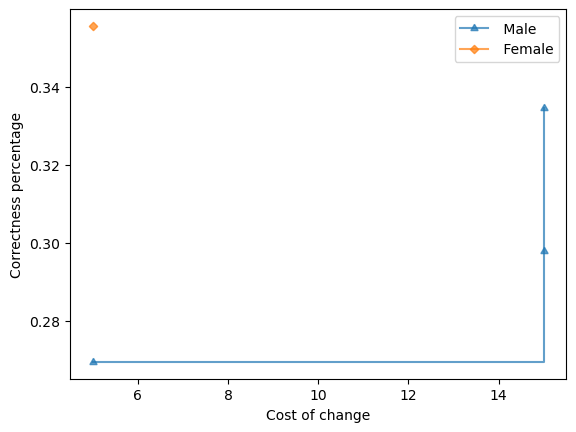

If age = (30.0, 34.0], capital-loss = (-4.356, 435.6], marital-status =  Never-married, native-country =  United-States:
	Protected Subgroup ' Male', 3.27% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 27.31% and counterfactual cost = 5.0.
		Make age = (34.0, 37.0], marital-status =  Married-civ-spouse with effectiveness 29.63% and counterfactual cost = 15.0.
		Make age = (37.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 32.87% and counterfactual cost = 15.0.
		Aggregate cost of the above recourses = 15.00
	Protected Subgroup ' Female', 4.05% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 36.69% and counterfactual cost = 5.0.
		Aggregate cost of the above recourses = 5.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


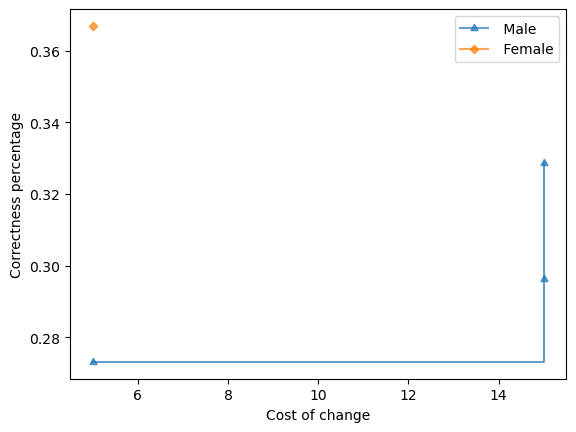

If age = (26.0, 30.0], marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.65% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 24.57% and counterfactual cost = 10.0.
		Make age = (30.0, 34.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.00% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 2.88% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 30.83% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


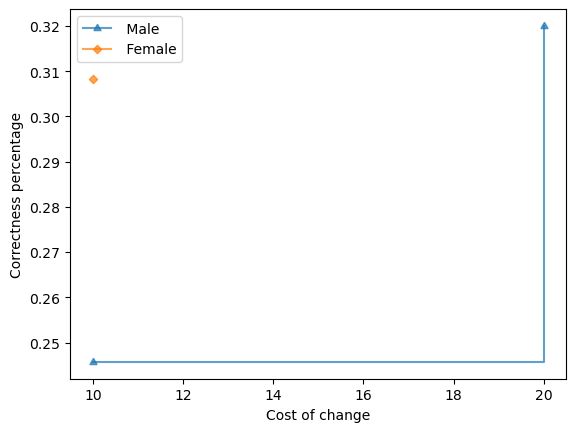

If age = (30.0, 34.0], hours-per-week = (30.4, 40.2], marital-status =  Never-married:
	Protected Subgroup ' Male', 2.38% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 20.38% and counterfactual cost = 5.0.
		Make hours-per-week = (40.2, 50.0], marital-status =  Married-civ-spouse with effectiveness 29.30% and counterfactual cost = 7.0.
		Make hours-per-week = (59.8, 69.6], marital-status =  Married-civ-spouse with effectiveness 29.30% and counterfactual cost = 11.0.
		Make age = (34.0, 37.0], marital-status =  Married-civ-spouse with effectiveness 29.30% and counterfactual cost = 15.0.
		Make age = (37.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 29.30% and counterfactual cost = 15.0.
		Make age = (34.0, 37.0], hours-per-week = (40.2, 50.0], marital-status =  Married-civ-spouse with effectiveness 34.39% and counterfactual cost = 17.0.
		Aggregate cost of the above recourses = 17.00
	Protected S

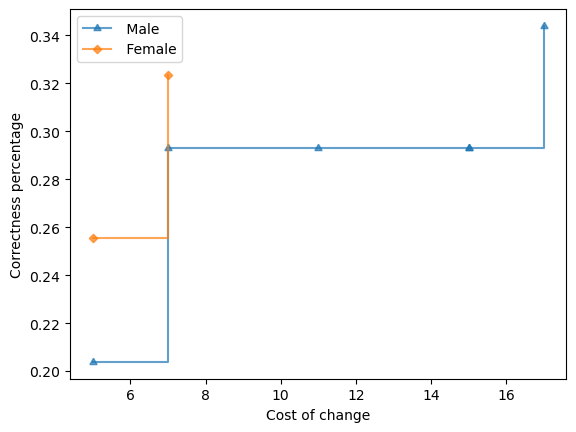

If age = (26.0, 30.0], hours-per-week = (30.4, 40.2], marital-status =  Never-married, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 2.21% covered (protected subgroup population size not given)
		Make marital-status =  Married-civ-spouse with effectiveness 13.01% and counterfactual cost = 5.0.
		Make hours-per-week = (40.2, 50.0], marital-status =  Married-civ-spouse with effectiveness 21.92% and counterfactual cost = 7.0.
		Make age = (30.0, 34.0], marital-status =  Married-civ-spouse with effectiveness 21.92% and counterfactual cost = 15.0.
		Make age = (34.0, 37.0], marital-status =  Married-civ-spouse with effectiveness 26.71% and counterfactual cost = 15.0.
		Make age = (30.0, 34.0], hours-per-week = (40.2, 50.0], marital-status =  Married-civ-spouse with effectiveness 30.14% and counterfactual cost = 17.0.
		Aggregate cost of the above recourses = 17.00
	Protected Subgroup ' Female', 2.78% covered (protected subgroup population size not given)
		Mak

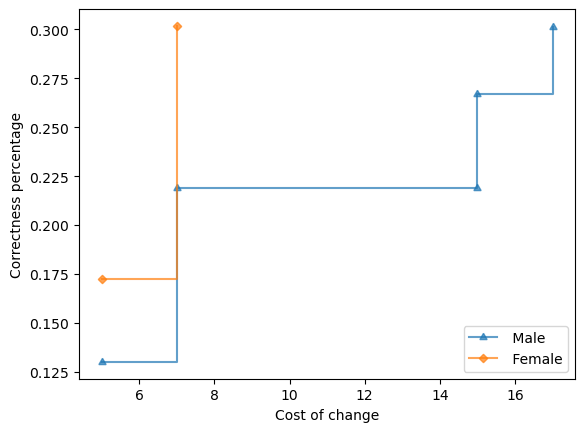

In [144]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

If Workclass =  Local-gov, capital-loss = (-4.356, 435.6], education-num = 10, native-country =  United-States:
	Protected Subgroup ' Male', 1.06% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Private with effectiveness 14.29% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 25.71% and counterfactual cost = 2.0.
		Make Workclass =  Private, education-num = 11 with effectiveness 25.71% and counterfactual cost = 5.0.
		Make Workclass =  Private, capital-loss = (1742.4, 2178.0] with effectiveness 61.43% and counterfactual cost = 6.0.
		Make Workclass =  Private, education-num = 12 with effectiveness 61.43% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.61
	Protected Subgroup ' Female', 1.65% covered (protected subgroup population size not given)
		Make Workclass =  Private with effectiveness 0.00% and counte

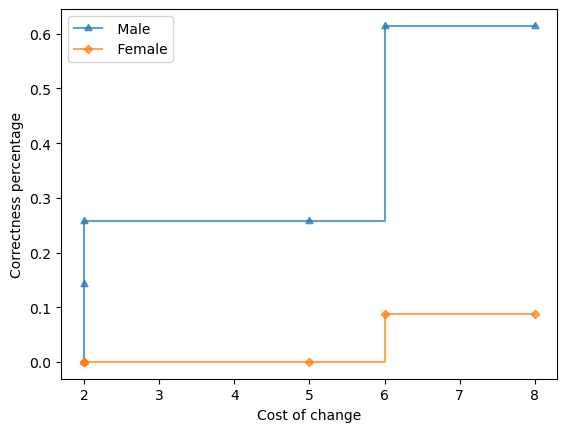

If capital-loss = (-4.356, 435.6], education-num = 9, hours-per-week = (30.4, 40.2], native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.14% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 20.00% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 20.00% and counterfactual cost = 4.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0] with effectiveness 49.33% and counterfactual cost = 5.0.
		Make hours-per-week = (40.2, 50.0], occupation =  Exec-managerial with effectiveness 61.33% and counterfactual cost = 6.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 61.33% and counterfactual cost = 7.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0], occupation =  Exec-managerial with effectiveness 64.00% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.64
	Protected Subgroup ' F

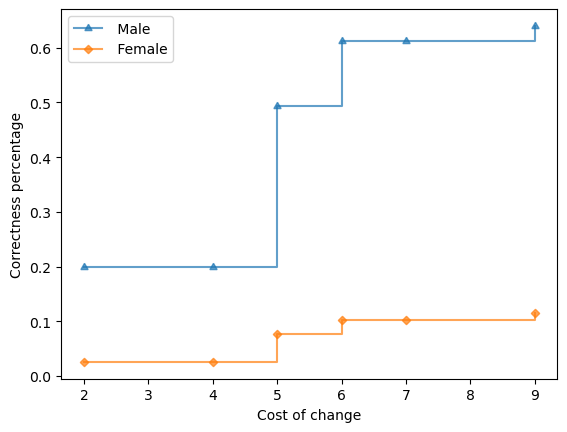

If education-num = 9, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 2.83% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 19.25% and counterfactual cost = 3.0.
		Make occupation =  Craft-repair with effectiveness 19.25% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 28.88% and counterfactual cost = 4.0.
		Make education-num = 10, occupation =  Craft-repair with effectiveness 28.88% and counterfactual cost = 7.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 38.50% and counterfactual cost = 7.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 45.45% and counterfactual cost = 7.0.
		Make education-num = 11, occupation =  Exec-managerial with effectiveness 57.75% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.58
	Protected Subgroup ' Female', 3.86% covered (prote

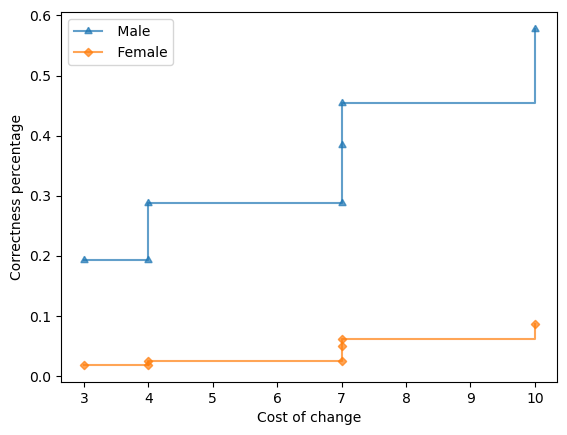

If age = (45.0, 50.0], education-num = 9, hours-per-week = (30.4, 40.2], race =  White:
	Protected Subgroup ' Male', 2.03% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 20.15% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 20.15% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0] with effectiveness 54.48% and counterfactual cost = 5.0.
		Aggregate cost of the above recourses = 0.54
	Protected Subgroup ' Female', 1.22% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 3.92% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 3.92% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0] with effectiveness 5.88% and counterfactual cost = 5.0.
		Aggregate cost of the above recourses = 0.06
	Bias against  Female due to Equal Effectiveness. Unfairn

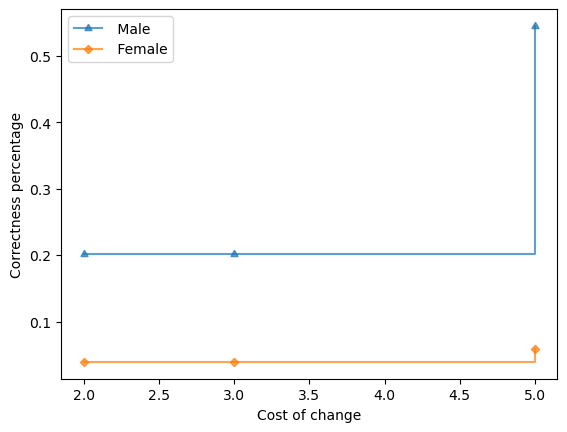

If age = (45.0, 50.0], education-num = 9, hours-per-week = (30.4, 40.2], native-country =  United-States:
	Protected Subgroup ' Male', 2.16% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 20.98% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 20.98% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0] with effectiveness 52.45% and counterfactual cost = 5.0.
		Make age = (50.0, 57.0] with effectiveness 52.45% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.52
	Protected Subgroup ' Female', 1.68% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 2.86% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 2.86% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0] with effectiveness 4.29% and counterfactual cost = 5.0.
		

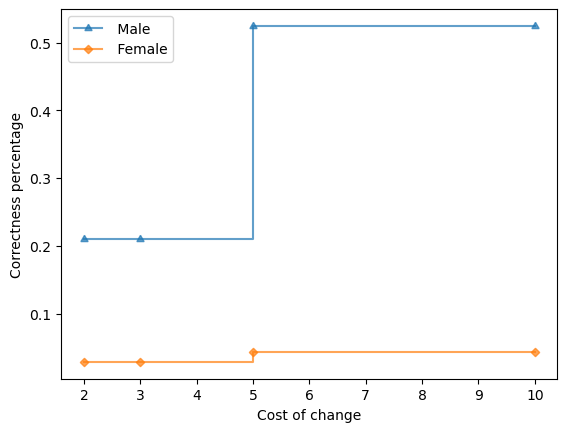

If Workclass =  Private, age = (45.0, 50.0], capital-loss = (-4.356, 435.6], native-country =  United-States:
	Protected Subgroup ' Male', 4.87% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 19.57% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 22.98% and counterfactual cost = 2.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 64.29% and counterfactual cost = 4.0.
		Make age = (50.0, 57.0] with effectiveness 64.29% and counterfactual cost = 10.0.
		Make age = (57.0, 90.0] with effectiveness 64.29% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.64
	Protected Subgroup ' Female', 5.08% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effe

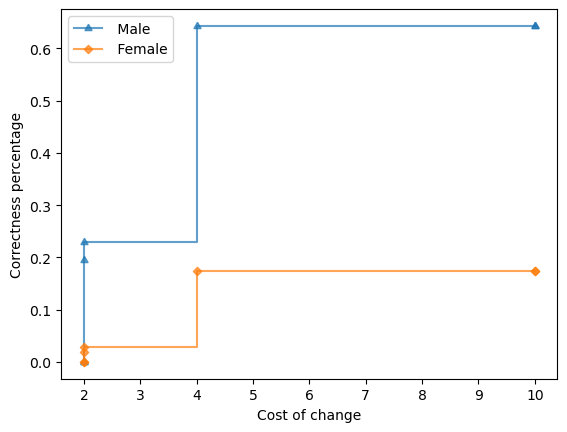

In [145]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

If capital-loss = (-4.356, 435.6], native-country =  United-States:
	Protected Subgroup ' Male', 87.86% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 39.29% and counterfactual cost = 4.0.
		Make capital-loss = (2178.0, 2613.6] with effectiveness 44.34% and counterfactual cost = 5.0.
	Protected Subgroup ' Female', 89.02% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 13.01% and counterfactual cost = 4.0.
		Make capital-loss = (2178.0, 2613.6] with effectiveness 17.19% and counterfactual cost = 5.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 12.92.
	Cumulative effectiveness plot for the above recourses:


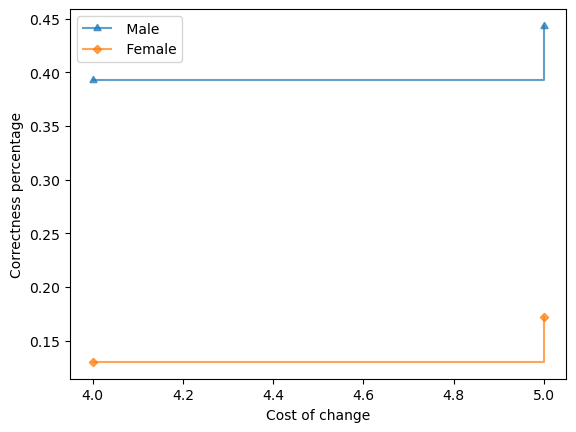

If capital-loss = (-4.356, 435.6]:
	Protected Subgroup ' Male', 96.97% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 37.68% and counterfactual cost = 4.0.
		Make capital-loss = (2178.0, 2613.6] with effectiveness 42.70% and counterfactual cost = 5.0.
	Protected Subgroup ' Female', 97.34% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 13.01% and counterfactual cost = 4.0.
		Make capital-loss = (2178.0, 2613.6] with effectiveness 17.02% and counterfactual cost = 5.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 12.8.
	Cumulative effectiveness plot for the above recourses:


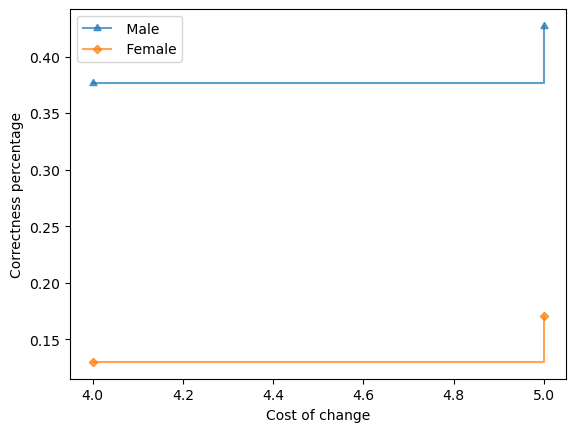

If capital-loss = (-4.356, 435.6], native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 77.74% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 41.30% and counterfactual cost = 4.0.
		Make capital-loss = (2178.0, 2613.6] with effectiveness 46.61% and counterfactual cost = 5.0.
		Make race =  Black with effectiveness 46.61% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 73.45% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 14.43% and counterfactual cost = 4.0.
		Make capital-loss = (2178.0, 2613.6] with effectiveness 18.67% and counterfactual cost = 5.0.
		Make race =  Black with effectiveness 18.67% and counterfactual cost = 100.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 12.24.
	Cumulative effectiveness plot for the above recourses:


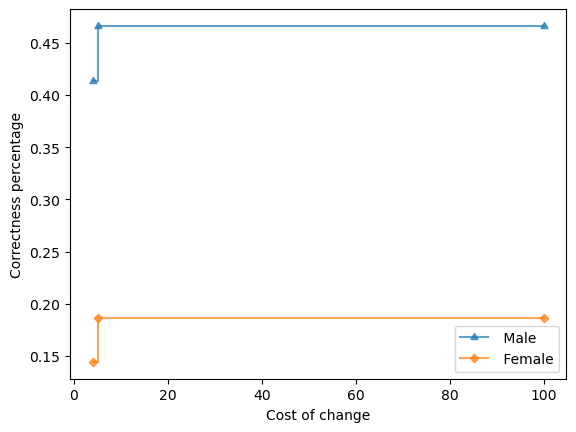

If capital-loss = (-4.356, 435.6], race =  White:
	Protected Subgroup ' Male', 84.18% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 39.59% and counterfactual cost = 4.0.
		Make capital-loss = (2178.0, 2613.6] with effectiveness 44.86% and counterfactual cost = 5.0.
		Make race =  Black with effectiveness 44.86% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 44.86% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 78.59% covered (protected subgroup population size not given)
		Make capital-loss = (1742.4, 2178.0] with effectiveness 14.19% and counterfactual cost = 4.0.
		Make capital-loss = (2178.0, 2613.6] with effectiveness 18.31% and counterfactual cost = 5.0.
		Make race =  Black with effectiveness 18.31% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 18.31% and counterfactual cost = 100.0.
	 Unfairness based on the Fair Effec

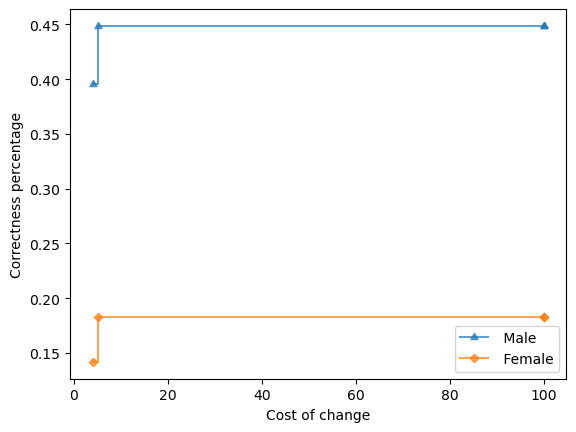

If Workclass =  Private, capital-loss = (-4.356, 435.6], native-country =  United-States:
	Protected Subgroup ' Male', 65.16% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 6.41% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 9.99% and counterfactual cost = 2.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 37.35% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, capital-loss = (1742.4, 2178.0] with effectiveness 37.35% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 69.40% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfa

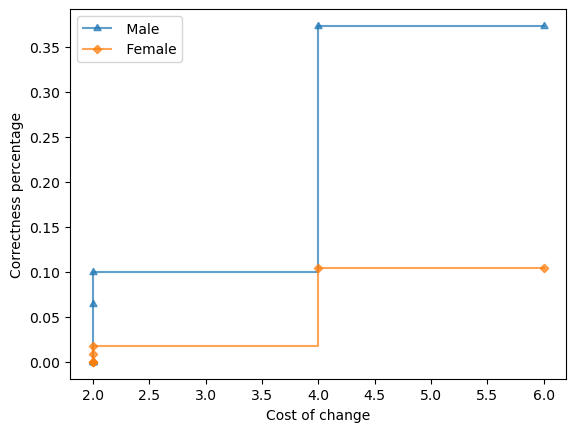

If capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 9:
	Protected Subgroup ' Male', 40.41% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 6.33% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 43.18% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 43.18% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 47.79% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 32.42% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 1.18% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 9.17% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 9.17% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 11.02% and cou

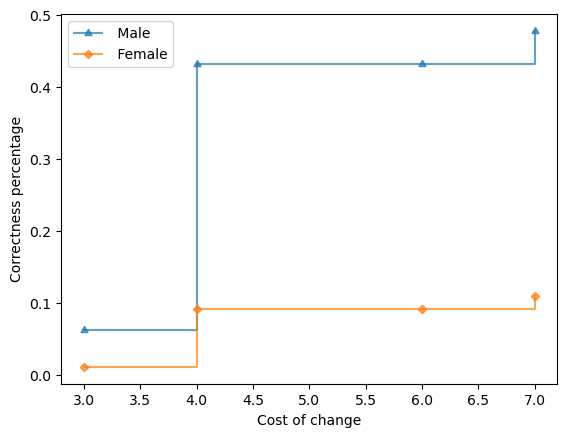

If capital-loss = (-4.356, 435.6], education-num = 9:
	Protected Subgroup ' Male', 40.41% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 6.33% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 43.18% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 43.18% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 47.79% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 32.42% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 1.18% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 9.17% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 9.17% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 11.02% and counterfactual cost = 7.0.
	 Unfairne

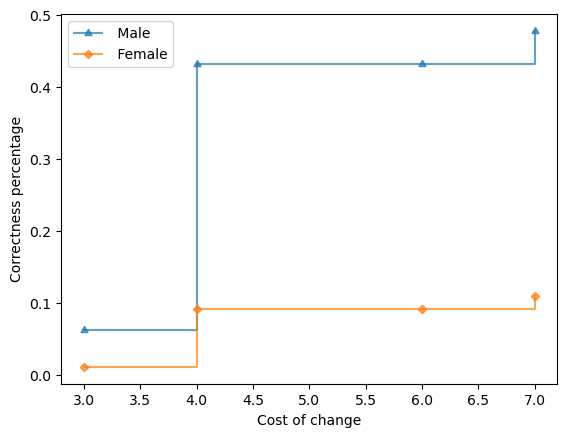

If Workclass =  Private, capital-loss = (-4.356, 435.6]:
	Protected Subgroup ' Male', 72.86% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 5.98% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 9.37% and counterfactual cost = 2.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 35.36% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, capital-loss = (1742.4, 2178.0] with effectiveness 35.36% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 76.55% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclas

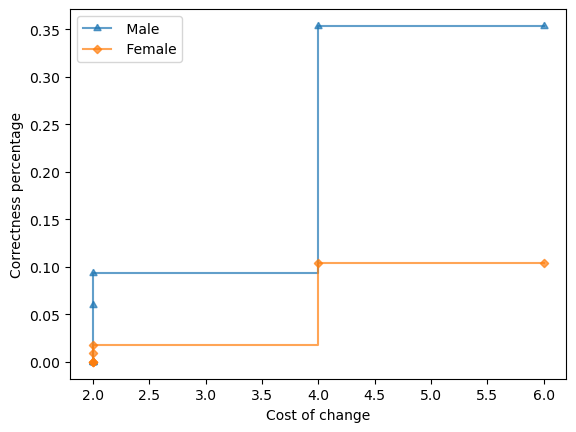

If Workclass =  Private, capital-loss = (-4.356, 435.6], native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 57.58% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 7.02% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 10.75% and counterfactual cost = 2.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 39.72% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, capital-loss = (1742.4, 2178.0] with effectiveness 39.72% and counterfactual cost = 6.0.
		Make race =  Black with effectiveness 39.72% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 57.99% covered (protected subgroup

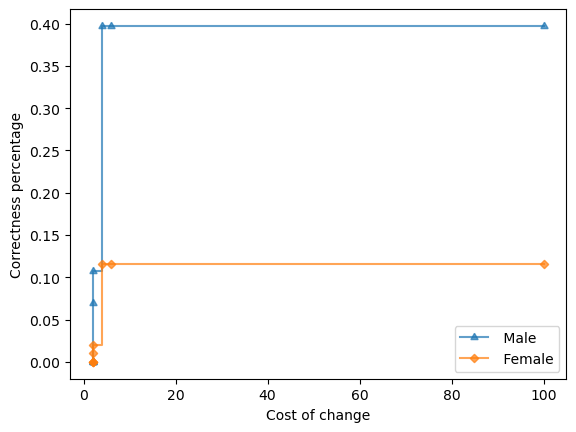

If capital-loss = (-4.356, 435.6], education-num = 9, native-country =  United-States:
	Protected Subgroup ' Male', 37.73% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 6.66% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 44.08% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 44.08% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 48.50% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 29.93% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 1.20% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 9.21% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 9.21% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 10.98% and coun

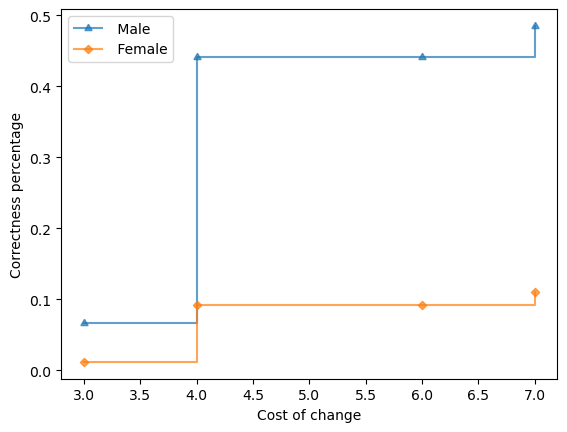

If capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 9, native-country =  United-States:
	Protected Subgroup ' Male', 37.73% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 6.66% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 44.08% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 44.08% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 48.50% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 29.93% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 1.20% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 9.21% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 9.21% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 

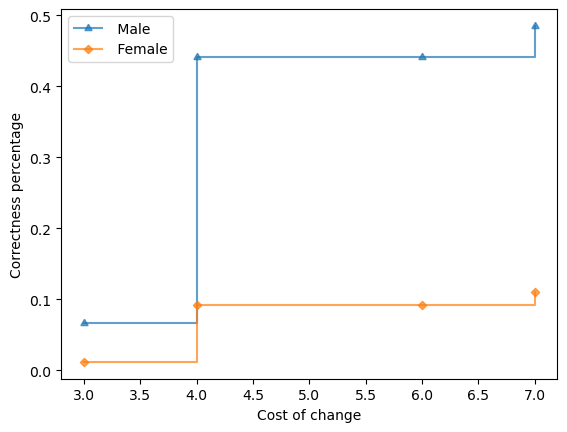

If capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 9, race =  White:
	Protected Subgroup ' Male', 35.22% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 6.96% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 46.24% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 46.24% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 50.92% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 26.14% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 1.47% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 9.72% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 9.72% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness

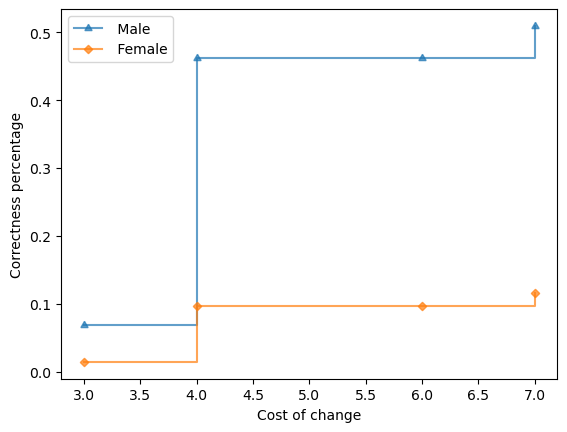

If capital-loss = (-4.356, 435.6], education-num = 9, race =  White:
	Protected Subgroup ' Male', 35.22% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 6.96% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 46.24% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 46.24% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 50.92% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 26.14% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 1.47% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 9.72% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 9.72% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 11.65% and counterfactual cost = 

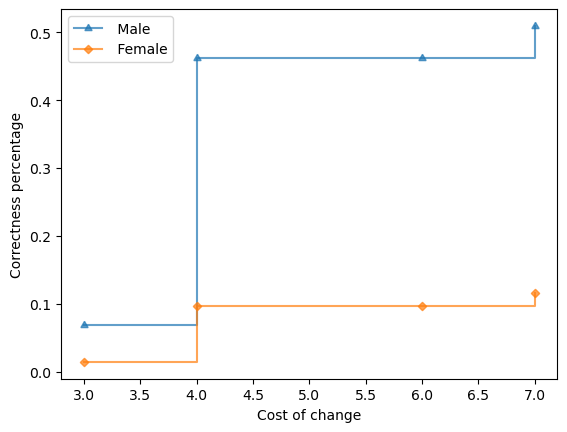

If Workclass =  Private, capital-loss = (-4.356, 435.6], race =  White:
	Protected Subgroup ' Male', 63.13% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 6.57% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 10.14% and counterfactual cost = 2.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 37.71% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, capital-loss = (1742.4, 2178.0] with effectiveness 37.71% and counterfactual cost = 6.0.
		Make race =  Black with effectiveness 37.71% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 37.71% and counterfactual cost = 100.0.
	Prot

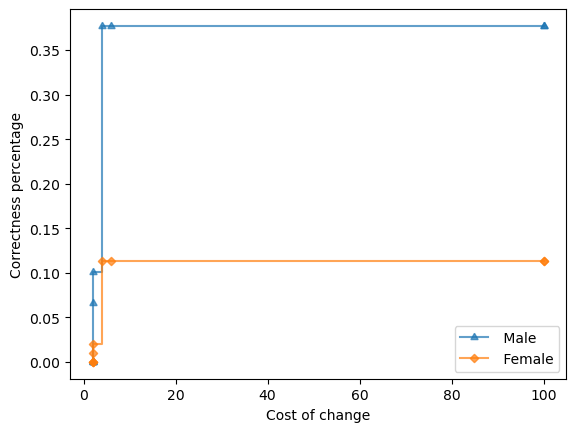

If capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 33.45% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 7.33% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 47.24% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 47.24% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 51.76% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 24.44% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 1.47% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 9.91% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 9.91% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], educ

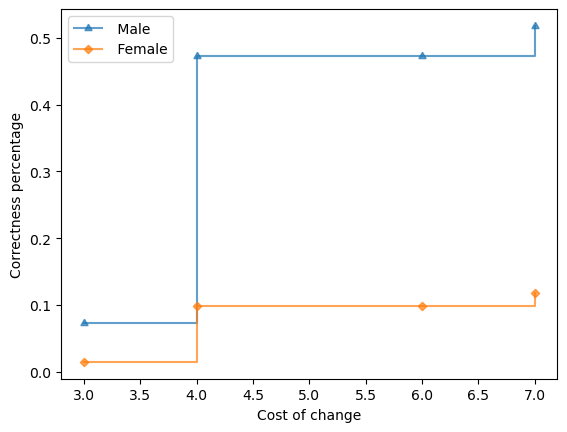

If capital-loss = (-4.356, 435.6], education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 33.45% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 7.33% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 47.24% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 47.24% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 51.76% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 24.44% covered (protected subgroup population size not given)
		Make education-num = 10 with effectiveness 1.47% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 9.91% and counterfactual cost = 4.0.
		Make education-num = 11 with effectiveness 9.91% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 

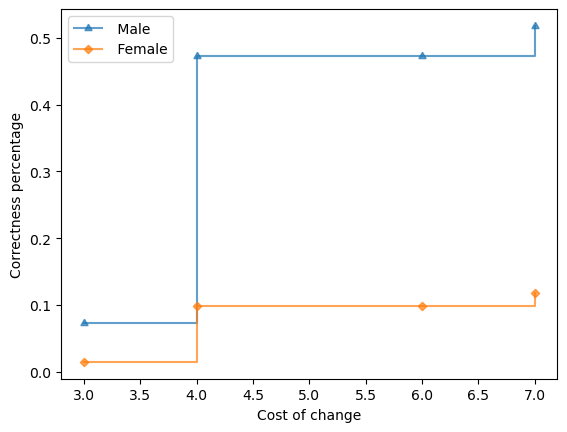

If Workclass =  Private, capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 9:
	Protected Subgroup ' Male', 31.44% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 5.78% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 5.87% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 42.22% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, education-num = 10 with effectiveness 42.22% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-inc, education-num = 10 with effectiveness 42.22% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 42.22% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 45.98% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 27.22% covered (protected subgroup population size not given)
		Make Workclass =  Sel

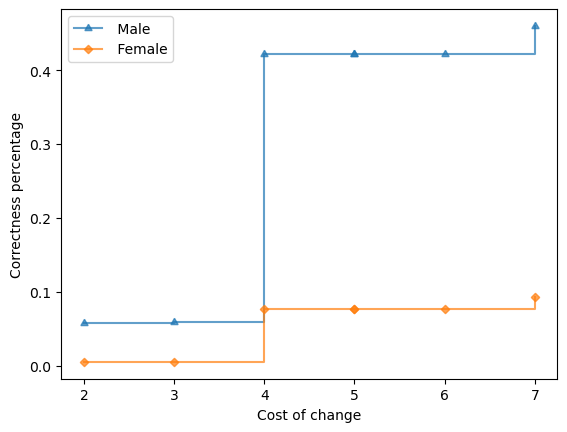

If Workclass =  Private, capital-loss = (-4.356, 435.6], education-num = 9:
	Protected Subgroup ' Male', 31.44% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 5.78% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 5.87% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 42.22% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, education-num = 10 with effectiveness 42.22% and counterfactual cost = 5.0.
		Make Workclass =  Local-gov, education-num = 10 with effectiveness 42.22% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-inc, education-num = 10 with effectiveness 42.22% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 42.22% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 45.98% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 27.22

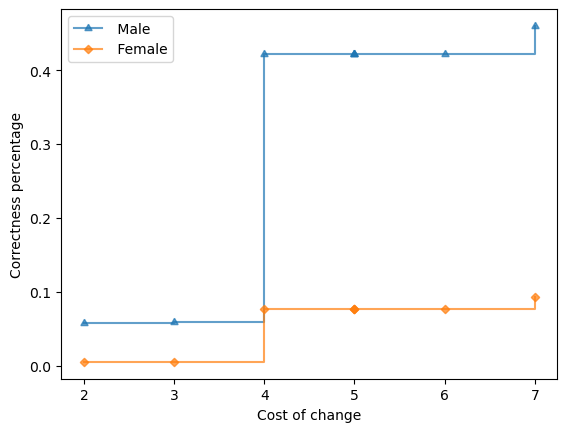

If capital-loss = (-4.356, 435.6], hours-per-week = (30.4, 40.2], native-country =  United-States:
	Protected Subgroup ' Male', 50.05% covered (protected subgroup population size not given)
		Make hours-per-week = (20.6, 30.4] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 9.92% and counterfactual cost = 2.0.
		Make hours-per-week = (50.0, 59.8] with effectiveness 10.28% and counterfactual cost = 4.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 38.07% and counterfactual cost = 4.0.
		Make hours-per-week = (59.8, 69.6] with effectiveness 38.07% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], hours-per-week = (40.2, 50.0] with effectiveness 46.11% and counterfactual cost = 6.0.
		Make hours-per-week = (69.6, 79.4] with effectiveness 46.11% and counterfactual cost = 8.0.
	Protected Subgroup ' Female', 52.81% covered (protected subgroup population size not given)
		Make hours-per-week = (2

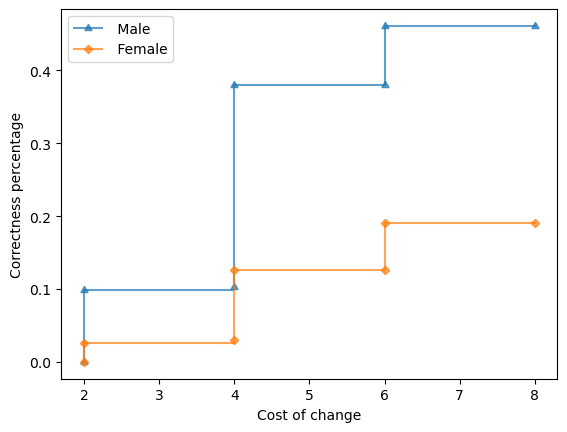

If Workclass =  Private, capital-loss = (-4.356, 435.6], education-num = 9, race =  White:
	Protected Subgroup ' Male', 27.43% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 6.46% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 6.57% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 45.75% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, education-num = 10 with effectiveness 45.75% and counterfactual cost = 5.0.
		Make Workclass =  Local-gov, education-num = 10 with effectiveness 45.75% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-inc, education-num = 10 with effectiveness 45.75% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 45.75% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 49.50% and counterfactual cost = 7.0.
	Protected Subgroup '

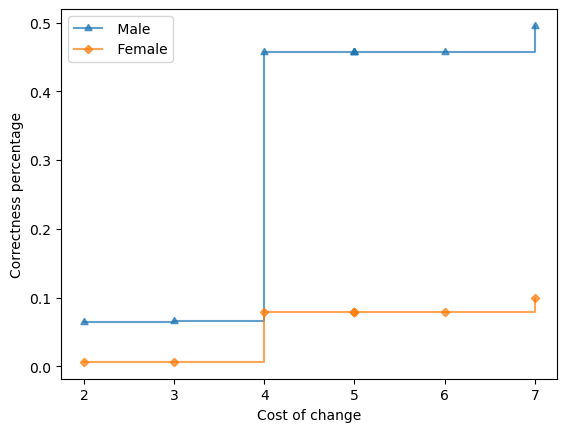

If Workclass =  Private, capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 9, race =  White:
	Protected Subgroup ' Male', 27.43% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 6.46% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 6.57% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 45.75% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, education-num = 10 with effectiveness 45.75% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-inc, education-num = 10 with effectiveness 45.75% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 45.75% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 49.50% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 22.04% covered (protected subgroup population size not given)
		Make W

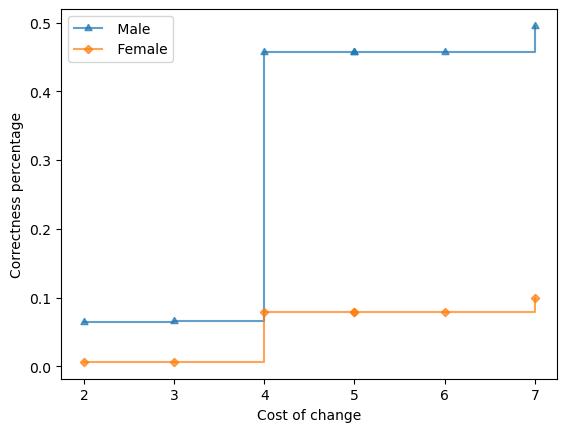

If Workclass =  Private, capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 9, native-country =  United-States:
	Protected Subgroup ' Male', 29.18% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 6.07% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 6.17% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 43.36% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, education-num = 10 with effectiveness 43.36% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-inc, education-num = 10 with effectiveness 43.36% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 43.36% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 46.99% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 25.01% covered (protected subgroup population size n

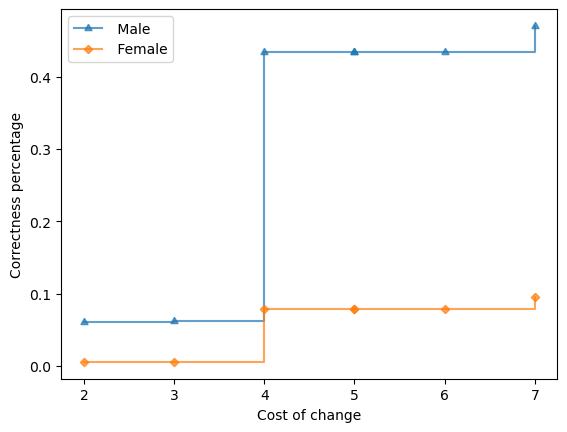

If Workclass =  Private, capital-loss = (-4.356, 435.6], education-num = 9, native-country =  United-States:
	Protected Subgroup ' Male', 29.18% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 6.07% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 6.17% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 43.36% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, education-num = 10 with effectiveness 43.36% and counterfactual cost = 5.0.
		Make Workclass =  Local-gov, education-num = 10 with effectiveness 43.36% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-inc, education-num = 10 with effectiveness 43.36% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 43.36% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 46.99% and counterfactual cost = 7.0.
	Pr

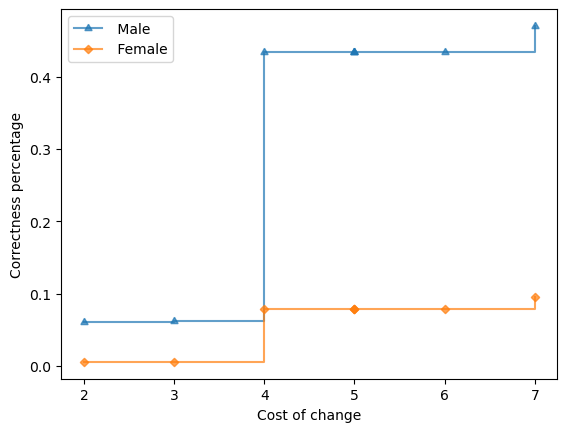

If capital-loss = (-4.356, 435.6], hours-per-week = (30.4, 40.2]:
	Protected Subgroup ' Male', 56.24% covered (protected subgroup population size not given)
		Make hours-per-week = (20.6, 30.4] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 9.45% and counterfactual cost = 2.0.
		Make hours-per-week = (50.0, 59.8] with effectiveness 9.80% and counterfactual cost = 4.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 36.19% and counterfactual cost = 4.0.
		Make hours-per-week = (59.8, 69.6] with effectiveness 36.19% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], hours-per-week = (40.2, 50.0] with effectiveness 44.21% and counterfactual cost = 6.0.
		Make hours-per-week = (69.6, 79.4] with effectiveness 44.21% and counterfactual cost = 8.0.
		Make capital-loss = (1742.4, 2178.0], hours-per-week = (59.8, 69.6] with effectiveness 44.21% and counterfactual cost = 10.0.
	Protected Subgroup ' Fem

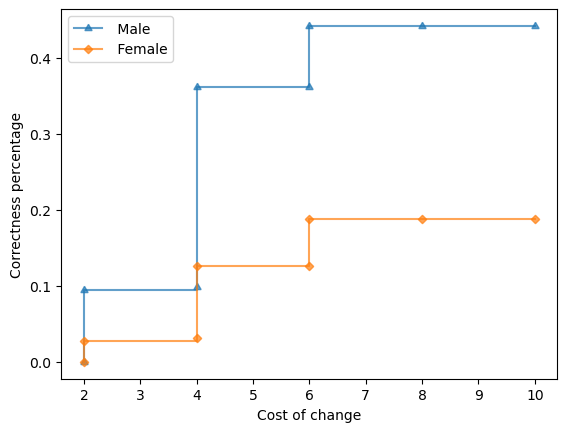

If Workclass =  Private, capital-loss = (-4.356, 435.6], education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 25.88% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 6.84% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 6.96% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 46.90% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, education-num = 10 with effectiveness 46.90% and counterfactual cost = 5.0.
		Make Workclass =  Local-gov, education-num = 10 with effectiveness 46.90% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-inc, education-num = 10 with effectiveness 46.90% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 46.90% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 50.58% and counterfactual 

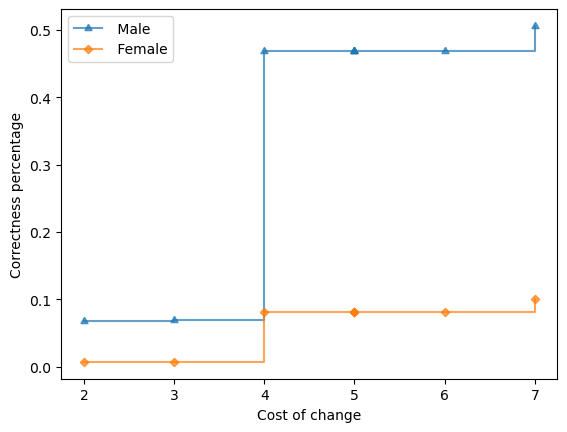

If Workclass =  Private, capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 25.88% covered (protected subgroup population size not given)
		Make Workclass =  Self-emp-inc with effectiveness 6.84% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 6.96% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 46.90% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, education-num = 10 with effectiveness 46.90% and counterfactual cost = 5.0.
		Make Workclass =  Self-emp-inc, education-num = 10 with effectiveness 46.90% and counterfactual cost = 5.0.
		Make education-num = 11 with effectiveness 46.90% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], education-num = 10 with effectiveness 50.58% and counterfactual cost = 7.0.
	Protected Subgroup ' Female', 20.50% covered (protected subgroup po

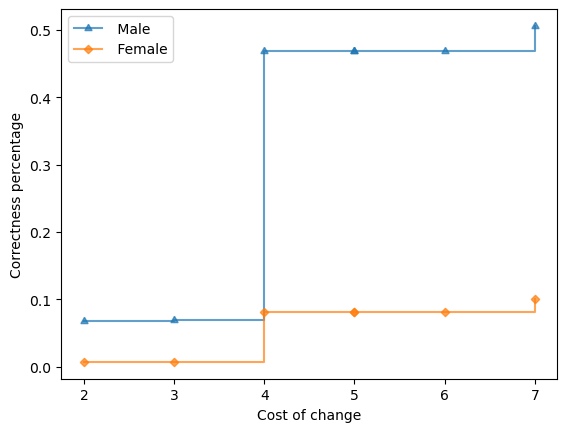

If capital-loss = (-4.356, 435.6], hours-per-week = (30.4, 40.2], native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 43.12% covered (protected subgroup population size not given)
		Make hours-per-week = (20.6, 30.4] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 10.49% and counterfactual cost = 2.0.
		Make hours-per-week = (50.0, 59.8] with effectiveness 10.92% and counterfactual cost = 4.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 40.33% and counterfactual cost = 4.0.
		Make hours-per-week = (59.8, 69.6] with effectiveness 40.33% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], hours-per-week = (40.2, 50.0] with effectiveness 48.61% and counterfactual cost = 6.0.
		Make hours-per-week = (69.6, 79.4] with effectiveness 48.61% and counterfactual cost = 8.0.
		Make race =  Black with effectiveness 48.61% and counterfactual cost = 100.0.
	Protected Subgroup ' F

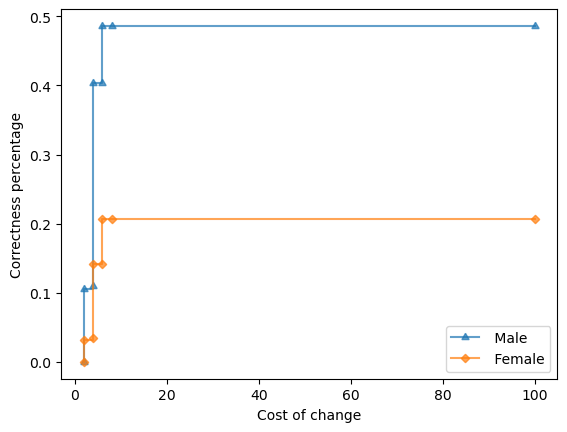

If Workclass =  Private, capital-loss = (-4.356, 435.6], hours-per-week = (30.4, 40.2], native-country =  United-States:
	Protected Subgroup ' Male', 38.81% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 4.60% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 7.49% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 8.35% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = (40.2, 50.0] with effectiveness 8.35% and counterfactual cost = 4.0.
		Make Workclass =  State-gov, hours-per-week = (40.2, 50.0] with effectiveness 8.35% and counterfactual cost = 4.0.
		Make Workc

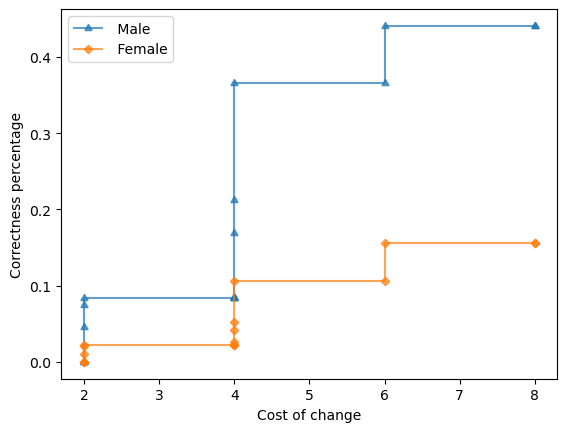

If capital-loss = (-4.356, 435.6], hours-per-week = (30.4, 40.2], race =  White:
	Protected Subgroup ' Male', 47.51% covered (protected subgroup population size not given)
		Make hours-per-week = (20.6, 30.4] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 10.04% and counterfactual cost = 2.0.
		Make hours-per-week = (50.0, 59.8] with effectiveness 10.42% and counterfactual cost = 4.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 38.20% and counterfactual cost = 4.0.
		Make hours-per-week = (59.8, 69.6] with effectiveness 38.20% and counterfactual cost = 6.0.
		Make capital-loss = (1742.4, 2178.0], hours-per-week = (40.2, 50.0] with effectiveness 46.42% and counterfactual cost = 6.0.
		Make hours-per-week = (69.6, 79.4] with effectiveness 46.42% and counterfactual cost = 8.0.
		Make capital-loss = (1742.4, 2178.0], hours-per-week = (59.8, 69.6] with effectiveness 46.42% and counterfactual cost = 10.0.
		Make r

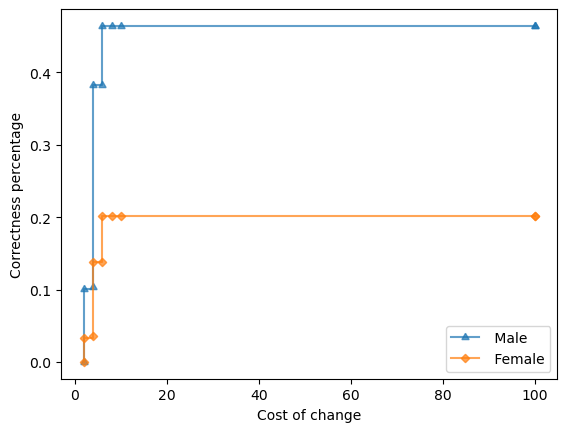

If Workclass =  Private, capital-loss = (-4.356, 435.6], hours-per-week = (30.4, 40.2]:
	Protected Subgroup ' Male', 44.35% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 4.37% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 7.13% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 7.99% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = (40.2, 50.0] with effectiveness 7.99% and counterfactual cost = 4.0.
		Make Workclass =  State-gov, hours-per-week = (40.2, 50.0] with effectiveness 7.99% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov, hours-per-week

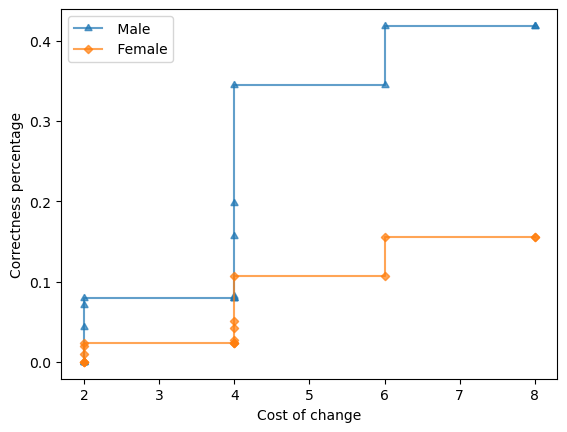

If Workclass =  Private, capital-loss = (-4.356, 435.6], hours-per-week = (30.4, 40.2], native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 33.59% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 5.05% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 8.11% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 9.06% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = (40.2, 50.0] with effectiveness 9.06% and counterfactual cost = 4.0.
		Make Workclass =  State-gov, hours-per-week = (40.2, 50.0] with effectiveness 9.06% and counterfactual cost = 4.

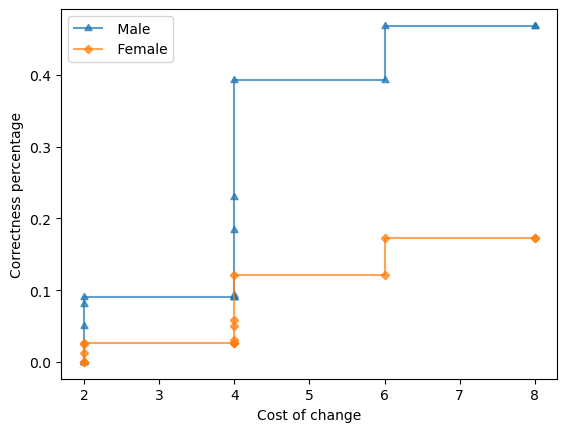

If Workclass =  Private, capital-loss = (-4.356, 435.6], hours-per-week = (30.4, 40.2], race =  White:
	Protected Subgroup ' Male', 37.54% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 4.80% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 7.74% and counterfactual cost = 2.0.
		Make hours-per-week = (40.2, 50.0] with effectiveness 8.71% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = (40.2, 50.0] with effectiveness 8.71% and counterfactual cost = 4.0.
		Make Workclass =  State-gov, hours-per-week = (40.2, 50.0] with effectiveness 8.71% and counterfactual cost = 4.0.
		Make Workclass =  Local-gov,

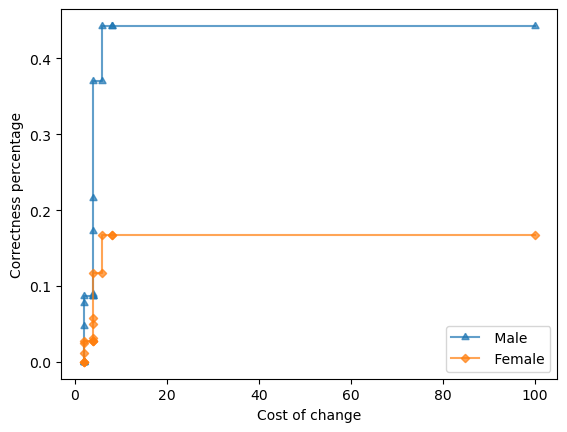

If capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 10, native-country =  United-States:
	Protected Subgroup ' Male', 19.90% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 10.87% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 40.84% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 40.84% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 24.60% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 1.85% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 7.60% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 7.60% and counterfactual cost = 6.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.98.
	Cumulative effectiveness plot for the above recourses:


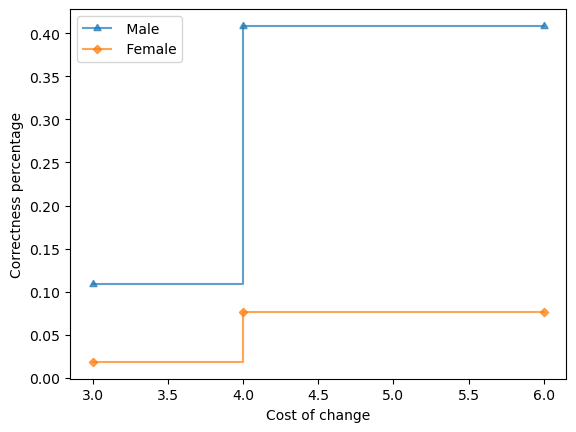

If capital-loss = (-4.356, 435.6], education-num = 10, native-country =  United-States:
	Protected Subgroup ' Male', 19.90% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 10.87% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 40.84% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 40.84% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 24.60% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 1.85% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 7.60% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 7.60% and counterfactual cost = 6.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.98.
	Cumulative effectiveness plot for the above recourses:


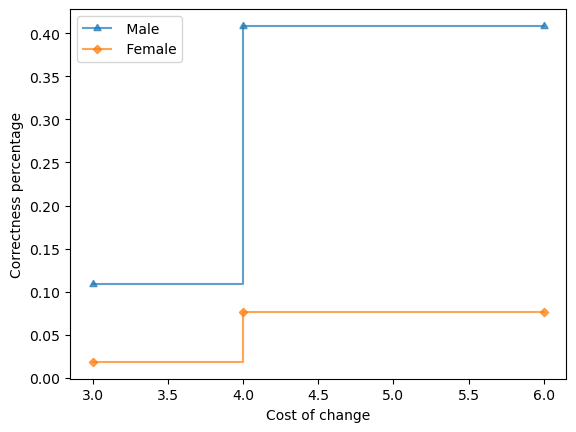

If capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 10:
	Protected Subgroup ' Male', 21.22% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 10.34% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 39.73% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 39.73% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 26.14% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 1.83% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 7.71% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 7.71% and counterfactual cost = 6.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.93.
	Cumulative effectiveness plot for the above recourses:


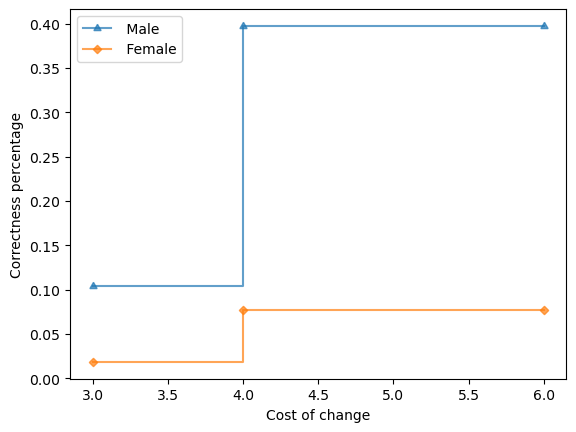

If capital-loss = (-4.356, 435.6], education-num = 10:
	Protected Subgroup ' Male', 21.22% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 10.34% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 39.73% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 39.73% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 26.14% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 1.83% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 7.71% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 7.71% and counterfactual cost = 6.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.93.
	Cumulative effectiveness plot for the above recourses:


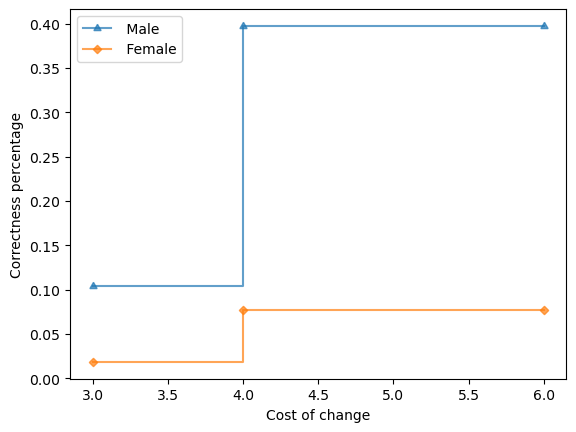

If capital-loss = (-4.356, 435.6], education-num = 9, hours-per-week = (30.4, 40.2]:
	Protected Subgroup ' Male', 24.75% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 6.24% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 6.24% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 41.35% and counterfactual cost = 4.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0] with effectiveness 41.35% and counterfactual cost = 5.0.
		Make hours-per-week = (59.8, 69.6] with effectiveness 41.35% and counterfactual cost = 6.0.
		Make education-num = 11 with effectiveness 41.35% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = (50.0, 59.8] with effectiveness 41.35% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = (40.2, 50.0] with effectiveness 41.35% and counterfactual cost = 8.0.
		Make education-num = 10, hours-p

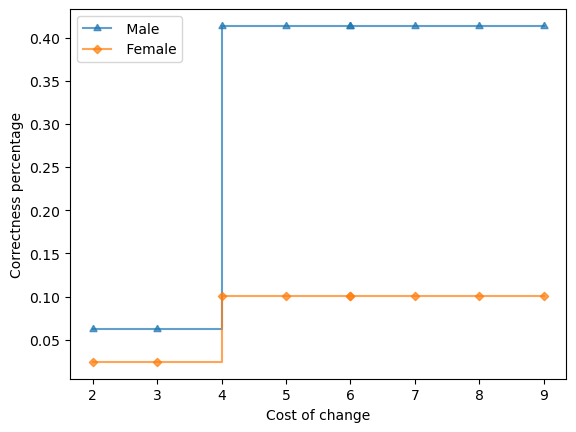

If capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 9, hours-per-week = (30.4, 40.2]:
	Protected Subgroup ' Male', 24.75% covered (protected subgroup population size not given)
		Make hours-per-week = (40.2, 50.0] with effectiveness 6.24% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 6.24% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 41.35% and counterfactual cost = 4.0.
		Make education-num = 10, hours-per-week = (40.2, 50.0] with effectiveness 41.35% and counterfactual cost = 5.0.
		Make hours-per-week = (59.8, 69.6] with effectiveness 41.35% and counterfactual cost = 6.0.
		Make education-num = 11 with effectiveness 41.35% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = (50.0, 59.8] with effectiveness 41.35% and counterfactual cost = 7.0.
		Make education-num = 11, hours-per-week = (40.2, 50.0] with effectiveness 41.35% and counterfactual cost = 8.0.


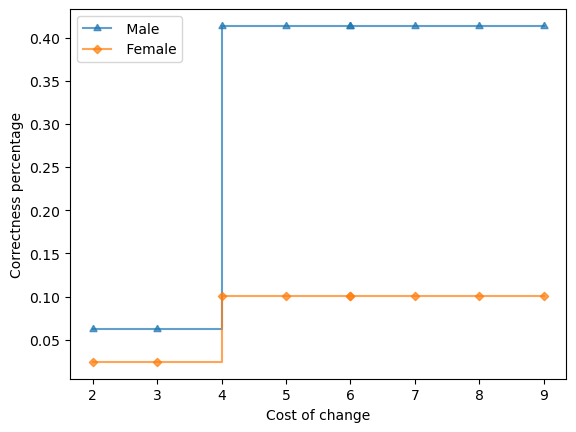

If capital-loss = (-4.356, 435.6], education-num = 10, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 17.48% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 11.08% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 41.47% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 41.47% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 20.34% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 2.00% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 8.14% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 8.14% and counterfactual cost = 6.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.37.
	Cumulative effectiveness plot for the above recourses:


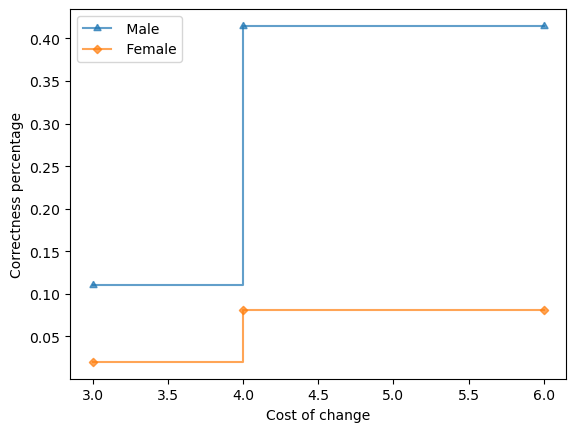

If capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 10, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 17.48% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 11.08% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 41.47% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 41.47% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 20.34% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 2.00% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 8.14% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 8.14% and counterfactual cost = 6.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.37.
	Cumulative effectiveness plot for the above recourses:


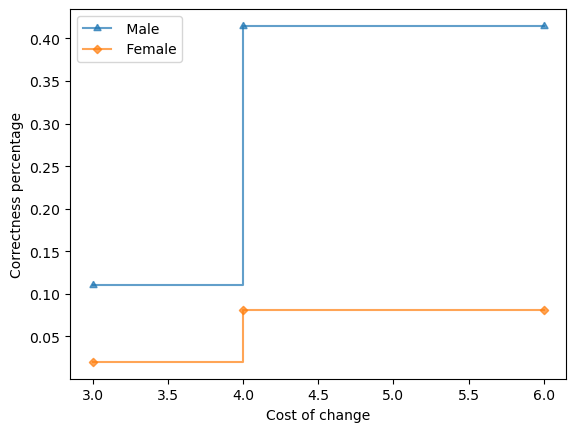

If capital-loss = (-4.356, 435.6], education-num = 10, race =  White:
	Protected Subgroup ' Male', 18.28% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 10.76% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 40.65% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 40.65% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 21.22% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 2.03% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 8.14% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 8.14% and counterfactual cost = 6.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.35.
	Cumulative effectiveness plot for the above recourses:


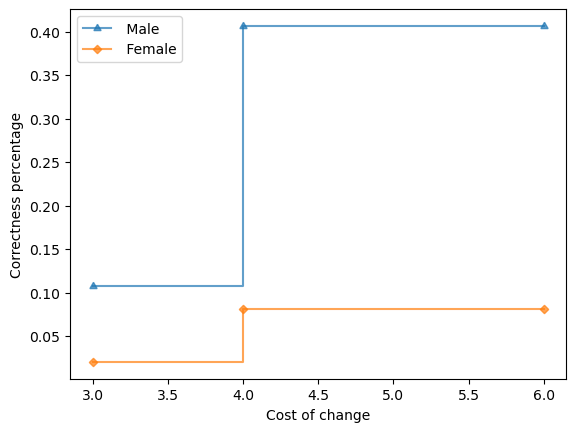

If capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 10, race =  White:
	Protected Subgroup ' Male', 18.28% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 10.76% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 40.65% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 40.65% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 21.22% covered (protected subgroup population size not given)
		Make education-num = 11 with effectiveness 2.03% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 8.14% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 8.14% and counterfactual cost = 6.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.35.
	Cumulative effectiveness plot for the above recourses:


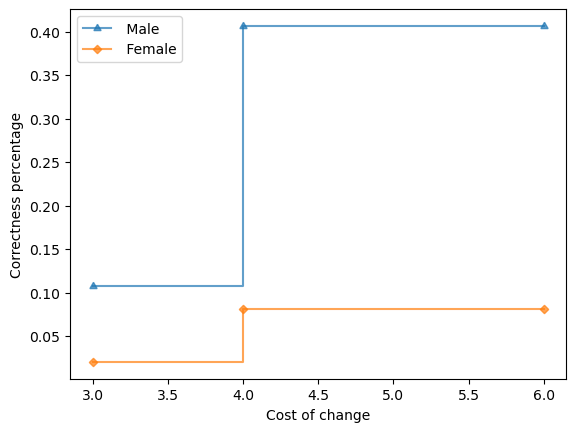

If capital-loss = (-4.356, 435.6], occupation =  Sales:
	Protected Subgroup ' Male', 9.05% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Transport-moving with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 4.35% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 11.20% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 13.21% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 18.23% and counterfactual cost = 4.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 45.65% and counterfactual cost = 4.0.
		Make capital-loss = (1742.4, 2178.0], occupation =  Prof-specialty with effectiveness 49.33% and counterfactual

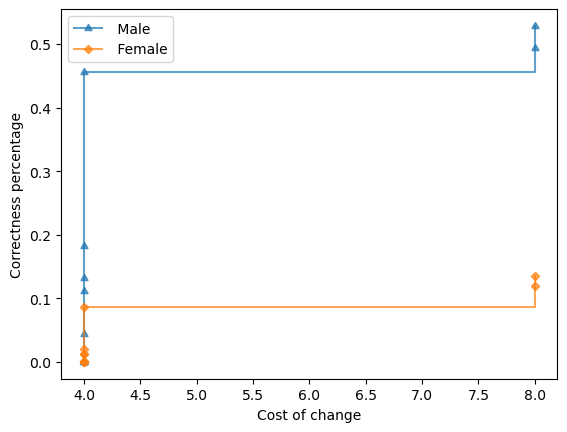

If capital-loss = (-4.356, 435.6], native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 8.45% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Transport-moving with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 4.66% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 11.65% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 13.80% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 18.82% and counterfactual cost = 4.0.
		Make capital-loss = (1742.4, 2178.0], occupation =  Prof-specialty with effectiveness 49.28% and counterfactual cost = 8.0.
		Make capital-loss = (1742.4, 2178.0], occupation

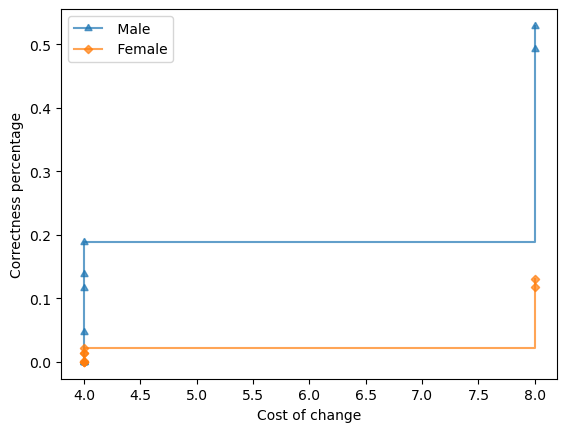

If Workclass =  Private, capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 10, native-country =  United-States:
	Protected Subgroup ' Male', 14.38% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 9.58% and counterfactual cost = 2.0.
		Make education-num = 11 with effectiveness 10.53% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 37.37% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 37.37% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 19.66% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 1.10% and counterfactual cost = 2.0.
		Make education-num = 11 with effectiveness 1.95% and count

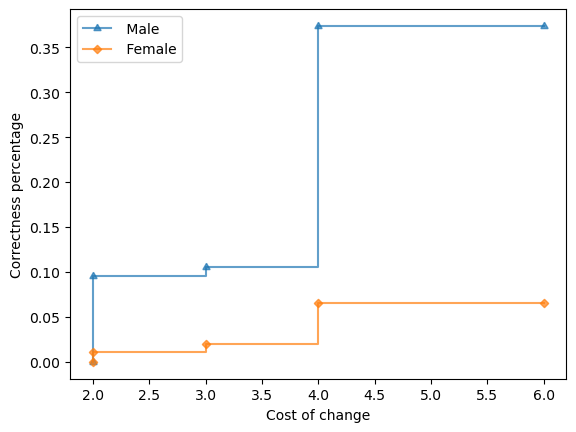

If Workclass =  Private, capital-loss = (-4.356, 435.6], education-num = 10, native-country =  United-States:
	Protected Subgroup ' Male', 14.38% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 9.58% and counterfactual cost = 2.0.
		Make education-num = 11 with effectiveness 10.53% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 37.37% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 37.37% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 19.66% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.

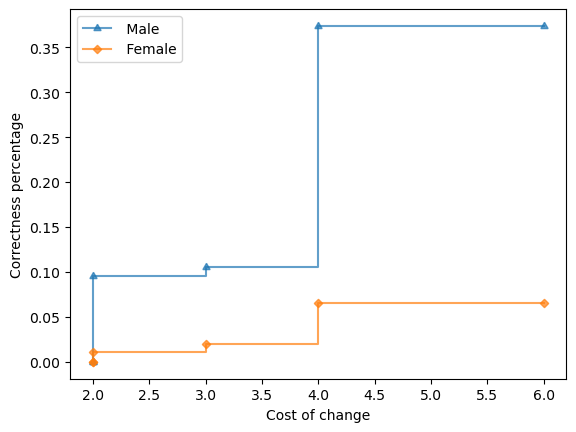

If Workclass =  Private, capital-loss = (-4.356, 435.6], education-num = 10:
	Protected Subgroup ' Male', 15.48% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 8.99% and counterfactual cost = 2.0.
		Make education-num = 11 with effectiveness 9.87% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 36.17% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 36.17% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 20.94% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-in

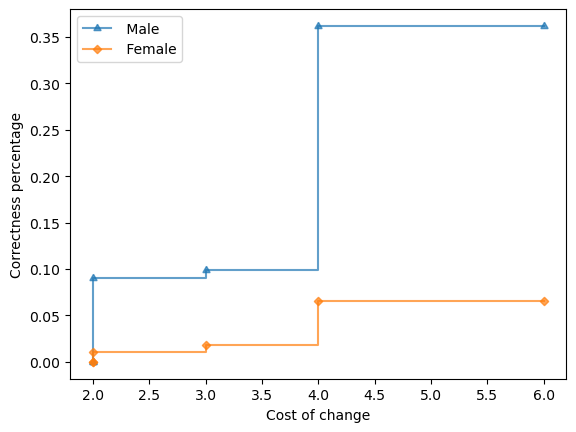

If Workclass =  Private, capital-gain = (-99.999, 9999.9], capital-loss = (-4.356, 435.6], education-num = 10:
	Protected Subgroup ' Male', 15.48% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 8.99% and counterfactual cost = 2.0.
		Make education-num = 11 with effectiveness 9.87% and counterfactual cost = 3.0.
		Make capital-loss = (1742.4, 2178.0] with effectiveness 36.17% and counterfactual cost = 4.0.
		Make education-num = 12 with effectiveness 36.17% and counterfactual cost = 6.0.
	Protected Subgroup ' Female', 20.94% covered (protected subgroup population size not given)
		Make Workclass =  Local-gov with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 1.03% and counterfactual cost = 2.0.
		Make education-num = 11 with effectiveness 1.83% and counterfactual cost = 3.0.
		Make capit

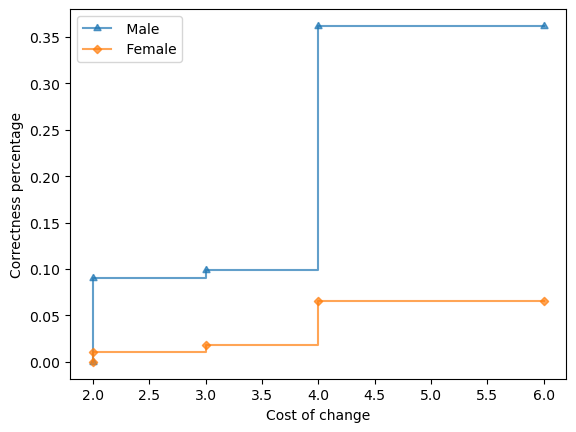

If capital-loss = (-4.356, 435.6], occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 8.07% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Transport-moving with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 4.69% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 11.63% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 13.88% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 19.14% and counterfactual cost = 4.0.
		Make capital-loss = (1742.4, 2178.0], occupation =  Prof-specialty with effectiveness 50.84% and counterfactual cost = 8.0.
		Make capital-loss = (1742.4, 2178.0], occupation =  Exec-manageria

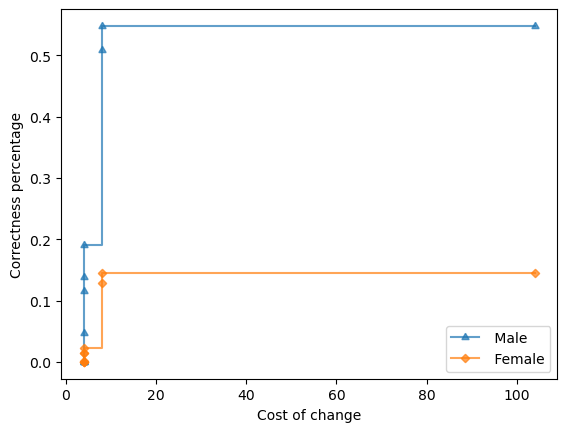

If capital-loss = (-4.356, 435.6], native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 7.75% covered (protected subgroup population size not given)
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Transport-moving with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 4.88% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 11.91% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 14.26% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 19.53% and counterfactual cost = 4.0.
		Make capital-loss = (1742.4, 2178.0], occupation =  Prof-specialty with effectiveness 50.78% and counterfactual cost = 8.0.
		Make capital-loss = (1742.4, 2178

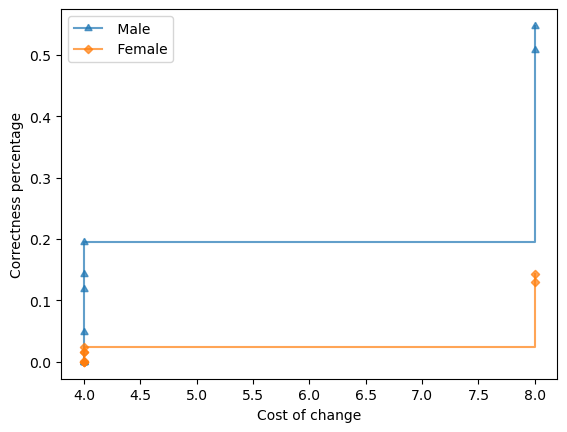

In [146]:
affected_pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)

In [147]:
end_time = time.time()

run_stats["metrics-time"] = end_time - start_time

In [148]:
try:
    all_stats
except NameError:
    all_stats = dict()

In [149]:
all_stats[(nbins, sup_thres)] = run_stats

In [150]:
save_object("scalability-stats.data", all_stats)

In [151]:
all_stats

{(10, 0.05): {'freq-itemsets-no': {' Female': 3024, ' Male': 3017},
  'inter-groups-no': 1583,
  'unaff-freq-itemsets-no': 7777,
  'triples-no': 3120,
  'subgroup-no': 1235,
  'valid-if-thens-time': 104.66306376457214,
  'cumulative-time': 64.15039730072021,
  'metrics-time': 10.436904668807983},
 (5, 0.05): {'freq-itemsets-no': {' Female': 4021, ' Male': 4017},
  'inter-groups-no': 1969,
  'unaff-freq-itemsets-no': 10709,
  'triples-no': 4348,
  'subgroup-no': 1706,
  'valid-if-thens-time': 161.85901808738708,
  'cumulative-time': 104.96623134613037,
  'metrics-time': 10.543078660964966},
 (20, 0.05): {'freq-itemsets-no': {' Female': 2397, ' Male': 2309},
  'inter-groups-no': 1126,
  'unaff-freq-itemsets-no': 5961,
  'triples-no': 2538,
  'subgroup-no': 887,
  'valid-if-thens-time': 94.15474820137024,
  'cumulative-time': 51.76561141014099,
  'metrics-time': 9.96228289604187},
 (10, 0.1): {'freq-itemsets-no': {' Female': 933, ' Male': 997},
  'inter-groups-no': 453,
  'unaff-freq-item